In [1]:
# ================================================================================
# CRITICAL MEMORY OPTIMIZATION FOR NASDAQ 100+ SCALE COMPUTATION
# ================================================================================

import os
import pandas as pd
import numpy as np
from functools import reduce
from operator import mul
from typing import Iterator, Dict, List, Any, Optional
import gc  # Garbage collection for memory management

# --- Core Memory Optimization Helpers ---

def iter_param_combinations(indicator_name: str, INDICATOR_PARAMS: Dict) -> Iterator[Dict[str, Any]]:
    """Yield parameter combinations lazily to avoid materializing large lists."""
    if indicator_name not in INDICATOR_PARAMS:
        return
    param_names = list(INDICATOR_PARAMS[indicator_name].keys())
    param_values = list(INDICATOR_PARAMS[indicator_name].values())
    from itertools import product
    for combo in product(*param_values):
        yield {param_names[i]: combo[i] for i in range(len(param_names))}


def count_param_combinations(indicator_name: str, INDICATOR_PARAMS: Dict) -> int:
    """Count combinations without generating them."""
    if indicator_name not in INDICATOR_PARAMS:
        return 0
    lengths = [len(v) for v in INDICATOR_PARAMS[indicator_name].values()]
    return reduce(mul, lengths, 1)


def _ensure_df(results_like):
    """Accept list[dict] or DataFrame and return a DataFrame view."""
    if isinstance(results_like, list):
        return pd.DataFrame(results_like)
    return results_like


# --- Optimized Calculation Functions ---

def calculate_signals_vectorized(ticker_data: pd.DataFrame, signals: pd.Series) -> Dict[str, Any]:
    """Vectorized calculation of strategy metrics without creating temporary DataFrames.
    Returns metrics as dict to avoid DataFrame overhead.
    """
    daily_return = ticker_data['Close'].pct_change()
    position = signals.shift(1).fillna(0).astype('float32')
    strategy_return = (position * daily_return).astype('float32')

    valid_returns = strategy_return.dropna()
    if valid_returns.empty:
        return {
            'total_return': np.nan, 'sharpe': np.nan, 'max_drawdown': np.nan,
            'win_rate': np.nan, 'total_signals': 0, 'buy_signals': 0, 'sell_signals': 0
        }

    total_return = float((1.0 + valid_returns).prod() - 1.0)

    if valid_returns.std() > 1e-8:
        sharpe = float((valid_returns.mean() / valid_returns.std()) * np.sqrt(252))
    else:
        sharpe = 0.0 # Or np.nan, depending on how you want to handle zero std

    # Max drawdown calculation (vectorized)
    equity = (1.0 + valid_returns).cumprod()
    running_max = equity.cummax()
    drawdown = (equity - running_max) / running_max
    max_drawdown = float(drawdown.min())

    win_rate = float((valid_returns > 0).mean())

    return {
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'total_signals': int(signals.notna().sum()),
        'buy_signals': int((signals == 1).sum()),
        'sell_signals': int((signals == -1).sum())
    }


def stream_results_to_csv(results: List[Dict], filename: str, mode: str = 'a') -> None:
    """Stream results to CSV without loading all data into memory."""
    if not results:
        return

    df_chunk = pd.DataFrame(results)
    file_exists = os.path.exists(filename)

    df_chunk.to_csv(
        filename,
        mode=mode,
        header=not file_exists,
        index=False
    )

    del df_chunk # Clear memory
    gc.collect()


def load_data_and_apply_indicators_chunked(
    raw_data: pd.DataFrame,
    tickers: List[str],
    apply_indicators_single_ticker_func: callable,
    chunk_size: int = 10
) -> pd.DataFrame:
    """
    Memory-efficient alternative to raw_data.groupby('Ticker').apply(apply_indicators_single_ticker_func).
    Processes tickers in chunks to control memory usage and avoids large intermediate DataFrames.
    `apply_indicators_single_ticker_func` should accept a single ticker's DataFrame and return a processed DataFrame.
    """
    processed_chunks = []

    for i in range(0, len(tickers), chunk_size):
        current_chunk_tickers = tickers[i:i + chunk_size]
        print(f"Processing data for tickers {i+1}-{i+len(current_chunk_tickers)} of {len(tickers)}...")

        # Filter raw_data for the current chunk of tickers
        chunk_data_raw = raw_data[raw_data['Ticker'].isin(current_chunk_tickers)].copy()

        chunk_results_list = []
        for ticker in current_chunk_tickers:
            ticker_df = chunk_data_raw[chunk_data_raw['Ticker'] == ticker].copy()
            if not ticker_df.empty:
                try:
                    processed_ticker_df = apply_indicators_single_ticker_func(ticker_df)
                    chunk_results_list.append(processed_ticker_df)
                except Exception as e:
                    print(f"Error applying indicators to {ticker}: {e}")

        if chunk_results_list:
            # Concatenate results for the current chunk
            combined_chunk_df = pd.concat(chunk_results_list, ignore_index=False) # Keep original index if meaningful
            processed_chunks.append(combined_chunk_df)

        del chunk_data_raw, chunk_results_list # Explicitly free memory
        gc.collect()

    if processed_chunks:
        return pd.concat(processed_chunks, ignore_index=False) # Final concat of all chunks
    return pd.DataFrame() # Return empty if no data processed


print("🚀 MEMORY OPTIMIZATION HELPERS LOADED! Ready for NASDAQ 100+ scale.")
print("Key features: Lazy parameter generation, vectorized calcs, streaming CSV, chunked data processing.")



🚀 MEMORY OPTIMIZATION HELPERS LOADED! Ready for NASDAQ 100+ scale.
Key features: Lazy parameter generation, vectorized calcs, streaming CSV, chunked data processing.


In [2]:
import pandas as pd
import numpy as np

# Define parameter ranges for each indicator (NO ADX, NO RSI, NO ATR, NO Entropy)
INDICATOR_PARAMS = {
    'KAMA': {
        'er_period': list(range(5, 8)),      # Efficiency ratio periods
        'fast_period': list(range(7, 12)),    # Fast EMA periods
        'slow_period': list(range(15, 25)),     # Slow EMA periods
    },
    'Supertrend': {
        'period': list(range(7, 16)),  # ATR period
        'multiplier': [1.0, 2.0,]  # ATR multiplier
    },
    'MFI': {
        'period': list(range(7, 15)),  # MFI period
        'overbought': [80],  # Sell when MFI > overbought
        'oversold': [20]  # Buy when MFI < oversold
    }
}

# Define buy signal logic for each indicator
def get_buy_signal(indicator_name: str, data: pd.Series, params: dict) -> pd.Series:
    """
    Generate buy signals for different indicators.
    Returns: 1 (buy), -1 (sell), 0 (hold), NaN (no signal)
    """
    if indicator_name == 'KAMA':
        short_kama = params.get('short_kama', pd.Series(index=data.index))
        long_kama = params.get('long_kama', pd.Series(index=data.index))
        
        crossover_up = (short_kama > long_kama) & (short_kama.shift(1) <= long_kama.shift(1))
        crossover_down = (short_kama < long_kama) & (short_kama.shift(1) >= long_kama.shift(1))
        
        signals = pd.Series(0, index=data.index)
        signals[crossover_up] = 1
        signals[crossover_down] = -1
        
        return signals

    elif indicator_name == 'Supertrend':
        supertrend = data
        close = params.get('close', pd.Series(index=data.index))
        
        return pd.Series(np.where(close > supertrend, 1, np.where(close < supertrend, -1, 0)), index=data.index)

    elif indicator_name == 'MFI':
        overbought = params.get('overbought', 80)
        oversold = params.get('oversold', 20)
        return pd.Series(np.where(data < oversold, 1, np.where(data > overbought, -1, 0)), index=data.index)

    return pd.Series([0] * len(data), index=data.index) # Default: no signal

print("✅ Core Indicator Params & Signal Logic Loaded (NO ADX, RSI, ATR, Entropy)!")
print(f"Available indicators: {list(INDICATOR_PARAMS.keys())}")
print(f"Example KAMA combinations: {count_param_combinations('KAMA', INDICATOR_PARAMS)}")
print(f"Example Supertrend combinations: {count_param_combinations('Supertrend', INDICATOR_PARAMS)}")
print(f"Example MFI combinations: {count_param_combinations('MFI', INDICATOR_PARAMS)}")



✅ Core Indicator Params & Signal Logic Loaded (NO ADX, RSI, ATR, Entropy)!
Available indicators: ['KAMA', 'Supertrend', 'MFI']
Example KAMA combinations: 150
Example Supertrend combinations: 18
Example MFI combinations: 8


In [3]:
# ================================================================================
# OPTIMIZED GRID SEARCH FUNCTION
# ================================================================================

def run_comprehensive_grid_search_optimized(
    data: pd.DataFrame,
    indicator_params: Dict,
    indicator_class,
    max_combinations_per_indicator: int = 0,
    stream_results_dir: Optional[str] = None,
    summary_interval: int = 100 # Print summary every N combinations
) -> Dict[str, Dict[str, List[Dict[str, Any]]]]:
    """
    Memory-optimized comprehensive grid search.
    - Iterates parameter combinations lazily.
    - Uses vectorized calculations for signals and metrics.
    - Stores results as list[dict] per (ticker, indicator) to save memory.
    - Optionally streams results to CSV files incrementally.
    """
    all_results: Dict[str, Dict[str, List[Dict[str, Any]]]] = {}
    tickers = pd.Index(data['Ticker']).unique().tolist()

    print("\n🚀 Starting Optimized Grid Search...")
    print(f"Processing {len(tickers)} tickers with {len(indicator_params)} indicators.")

    for ticker in tickers:
        print(f"\n📊 Processing {ticker}...")
        ticker_data = data.loc[data['Ticker'] == ticker].copy()
        ticker_data.sort_index(inplace=True) # Ensure data is sorted by date
        
        # Initialize Indicator class for the current ticker's data
        indicator_obj = indicator_class(ticker_data)
        all_results[ticker] = {}

        for indicator_name, _ in indicator_params.items():
            total_combos = count_param_combinations(indicator_name, indicator_params)
            if total_combos == 0:
                print(f"    No combinations for {indicator_name}. Skipping.")
                continue
            
            current_limit = max_combinations_per_indicator if max_combinations_per_indicator > 0 else total_combos
            if current_limit < total_combos:
                print(f"    📉 Limiting {indicator_name} to {current_limit} random combinations out of {total_combos}.")
                # For true random sampling, we would need to materialize a subset.
                # For lazy iteration, we can just take the first N, or implement a reservoir sampling if needed.
                # For now, we take the first N as iterated.
            else:
                print(f"    🔁 Evaluating {total_combos} {indicator_name} combinations.")

            indicator_results: List[Dict[str, Any]] = []
            processed_count = 0
            batch_to_stream: List[Dict[str, Any]] = []

            for params in iter_param_combinations(indicator_name, indicator_params):
                processed_count += 1
                if max_combinations_per_indicator > 0 and processed_count > max_combinations_per_indicator:
                    break # Stop if limit reached
                
                if processed_count % summary_interval == 0 or processed_count == current_limit:
                    print(f"      -> Processed {processed_count}/{current_limit} combinations for {indicator_name}...")

                try:
                    # Calculate indicator values
                    # (Ensure these indicator_obj methods exist and return pd.Series)
                    indicator_values = pd.Series([]) # Default empty Series
                    if indicator_name == 'KAMA':
                        indicator_values = indicator_obj.kama(
                            er_period=params['er_period'],
                            fast_period=params['fast_period'],
                            slow_period=params['slow_period']
                        )
                    elif indicator_name == 'Supertrend':
                        indicator_values = indicator_obj.supertrend(period=params['period'], multiplier=params['multiplier'])
                    elif indicator_name == 'MFI':
                        indicator_values = indicator_obj.mfi(params['period'])
                    else:
                        print(f"        Unknown indicator {indicator_name}. Skipping combination.")
                        continue

                    # Generate signals using the global get_buy_signal function
                    # Pass ticker_data['Close'] if needed for KAMA/Supertrend signal logic
                    signal_params = params.copy()
                    if indicator_name == 'KAMA' or indicator_name == 'Supertrend':
                        signal_params['close'] = ticker_data['Close']
                    signals = get_buy_signal(indicator_name, indicator_values, signal_params)

                    # Calculate metrics using the vectorized function
                    metrics = calculate_signals_vectorized(ticker_data, signals)

                    # Store results for this combination
                    result_entry = {
                        'Ticker': ticker,
                        'Indicator': indicator_name,
                        'Parameters': params,
                        **metrics # Unpack all calculated metrics
                    }
                    indicator_results.append(result_entry)
                    batch_to_stream.append(result_entry)

                    # Stream results if batch size reached or last combination
                    if stream_results_dir and (len(batch_to_stream) >= 500 or processed_count == current_limit):
                        stream_filename = os.path.join(stream_results_dir, f"{ticker}_{indicator_name}_results.csv")
                        stream_results_to_csv(batch_to_stream, stream_filename)
                        batch_to_stream.clear() # Clear batch after streaming
                        gc.collect()

                except Exception as e:
                    print(f"    ❌ Error with {indicator_name} params {params}: {e}")
                    # Optionally log error to file
                    continue
            
            # Stream any remaining results in batch_to_stream
            if stream_results_dir and batch_to_stream:
                stream_filename = os.path.join(stream_results_dir, f"{ticker}_{indicator_name}_results.csv")
                stream_results_to_csv(batch_to_stream, stream_filename)
                batch_to_stream.clear()
                gc.collect()

            # Store final list of results for this (ticker, indicator)
            all_results[ticker][indicator_name] = indicator_results

            # Show best result for this indicator (from in-memory list)
            if indicator_results:
                try:
                    # Use _ensure_df to safely convert for analysis if needed (though it's a list here)
                    results_df_for_display = pd.DataFrame(indicator_results)
                    valid_sharpes = results_df_for_display['sharpe'].dropna()
                    if not valid_sharpes.empty:
                        best_idx = valid_sharpes.idxmax()
                        best_result = results_df_for_display.loc[best_idx]
                        print(f"    ✅ Best {indicator_name} for {ticker}: Sharpe={best_result['sharpe']:.3f}, Return={best_result['total_return']:.3f}")
                    else:
                        print(f"    ⚠️ No valid Sharpe Ratios for {indicator_name} for {ticker}.")
                except Exception as e:
                    print(f"    ⚠️ Error showing best result for {indicator_name} for {ticker}: {e}")

        # Explicitly clear ticker_data to free memory after all indicators processed for ticker
        del ticker_data, indicator_obj
        gc.collect()

    print("\n✅ Optimized Grid Search Complete!")
    return all_results



In [4]:
# ================================================================================
# OPTIMIZED RESULTS ANALYSIS AND PLOTTING FUNCTIONS
# ================================================================================

def analyze_grid_search_results_optimized(all_results: Dict[str, Dict[str, List[Dict[str, Any]]]]) -> Dict[str, Any]:
    """
    Updated to accept list- or DataFrame-backed results from the optimized grid search.
    """
    analysis = {
        'best_per_ticker': {},
        'best_indicators_overall': {},
        'summary_stats': {},
        'top_overall_sharpe': {},
        'top_overall_return': {}
    }

    print("\n🔍 Analyzing Grid Search Results...")

    # Best indicator per ticker
    for ticker, ticker_results in all_results.items():
        best_sharpe = -np.inf
        best_return = -np.inf
        best_indicator = None
        best_params = None
        best_result_row = None

        for indicator_name, results_list in ticker_results.items():
            df = _ensure_df(results_list)
            if df.empty or 'sharpe' not in df.columns or 'total_return' not in df.columns:
                continue
            
            # Ensure numeric columns are float and handle NaNs
            df['sharpe'] = pd.to_numeric(df['sharpe'], errors='coerce')
            df['total_return'] = pd.to_numeric(df['total_return'], errors='coerce')

            # Find best sharpe within this indicator for this ticker
            max_sharpe_idx = df['sharpe'].idxmax()
            if pd.notna(max_sharpe_idx):
                current_result_row = df.loc[max_sharpe_idx]
                current_sharpe = current_result_row['sharpe']
                current_return = current_result_row['total_return']

                if current_sharpe > best_sharpe:
                    best_sharpe = current_sharpe
                    best_return = current_return
                    best_indicator = indicator_name
                    best_params = current_result_row['Parameters']
                    best_result_row = current_result_row.to_dict()

        if best_indicator:
            analysis['best_per_ticker'][ticker] = {
                'indicator': best_indicator,
                'sharpe': best_sharpe,
                'total_return': best_return,
                'params': best_params,
                'full_result': best_result_row
            }
            print(f"  {ticker}: Best is {best_indicator} (Sharpe: {best_sharpe:.3f}, Return: {best_return:.3f})")
        else:
            analysis['best_per_ticker'][ticker] = {'indicator': None, 'sharpe': np.nan, 'total_return': np.nan, 'params': None, 'full_result': None}
            print(f"  {ticker}: No valid best indicator found.")

    # Best performing indicators overall (average Sharpe)
    indicator_performance: Dict[str, List[float]] = {}
    all_sharpes_overall: List[float] = []
    all_returns_overall: List[float] = []

    for _ticker, ticker_results in all_results.items():
        for indicator_name, results_list in ticker_results.items():
            df = _ensure_df(results_list)
            if df.empty or 'sharpe' not in df.columns or 'total_return' not in df.columns:
                continue
            
            # Ensure numeric columns and filter NaNs
            sharpes = pd.to_numeric(df['sharpe'], errors='coerce').dropna().tolist()
            returns = pd.to_numeric(df['total_return'], errors='coerce').dropna().tolist()
            
            if sharpes: # Only add if there are valid sharpe values
                indicator_performance.setdefault(indicator_name, []).extend(sharpes)
                all_sharpes_overall.extend(sharpes)
                all_returns_overall.extend(returns) # Also collect returns for overall stats

    best_indicators_overall = {
        k: (np.nanmean(v) if len(v) > 0 else np.nan) for k, v in indicator_performance.items()
    }
    analysis['best_indicators_overall'] = dict(sorted(best_indicators_overall.items(), key=lambda x: (-np.nan_to_num(x[1]), x[0])))

    # Top overall Sharpe and Return (across all tickers, all indicators)
    if all_sharpes_overall and all_returns_overall:
        temp_df = pd.DataFrame({'sharpe': all_sharpes_overall, 'total_return': all_returns_overall})
        if not temp_df.empty:
            top_sharpe_idx = temp_df['sharpe'].idxmax()
            top_return_idx = temp_df['total_return'].idxmax()
            analysis['top_overall_sharpe'] = temp_df.loc[top_sharpe_idx].to_dict()
            analysis['top_overall_return'] = temp_df.loc[top_return_idx].to_dict()

    # Summary statistics
    analysis['summary_stats'] = {
        'num_tickers_processed': len(all_results),
        'num_indicators_evaluated': len(indicator_performance),
        'avg_sharpe_across_all_combos': float(np.nanmean(all_sharpes_overall)) if len(all_sharpes_overall) else np.nan,
        'avg_return_across_all_combos': float(np.nanmean(all_returns_overall)) if len(all_returns_overall) else np.nan,
    }
    print("✅ Analysis Complete.")
    return analysis


def create_results_summary_table_optimized(
    all_results: Dict[str, Dict[str, List[Dict[str, Any]]]],
    output_file: Optional[str] = None
) -> pd.DataFrame:
    """
    Create a flat summary table from optimized grid search results, accepting list-backed results.
    """
    print("\n📝 Creating Summary Table...")
    summary_rows: List[Dict[str, Any]] = []
    for ticker, ticker_results in all_results.items():
        for indicator_name, results_list in ticker_results.items():
            df = _ensure_df(results_list)
            if df.empty:
                continue
            for _, row in df.iterrows():
                summary_rows.append({
                    'Ticker': ticker,
                    'Indicator': indicator_name,
                    'Parameters': row.get('Parameters'),
                    'Sharpe_Ratio': row.get('sharpe'),
                    'Total_Return': row.get('total_return'),
                    'Max_Drawdown': row.get('max_drawdown'),
                    'Win_Rate': row.get('win_rate'),
                    'Total_Signals': row.get('total_signals'),
                    'Buy_Signals': row.get('buy_signals'),
                    'Sell_Signals': row.get('sell_signals'),
                })

    summary_df = pd.DataFrame(summary_rows)
    if output_file:
        os.makedirs(os.path.dirname(output_file) or '.', exist_ok=True)
        summary_df.to_csv(output_file, index=False)
        print(f"📊 Summary results saved to {output_file}")
    print("✅ Summary Table Created.")
    return summary_df


def find_similar_parameter_combinations_optimized(
    results_like,
    target_params: Dict[str, Any],
    max_distance: float = 5.0
) -> pd.DataFrame:
    """
    Find similar parameter combinations, accepting list or DataFrame for results.
    """
    print(f"\n🔎 Finding similar parameters to {target_params} within distance {max_distance}...")
    df = _ensure_df(results_like)
    if df.empty or 'Parameters' not in df.columns:
        print("No valid results or 'Parameters' column found for similarity search.")
        return pd.DataFrame()

    similar_results: List[Dict[str, Any]] = []

    # Need to redefine calculate_param_distance or move it to a common helper if it's not globally available
    # Assuming calculate_param_distance is available globally or can be defined here if needed.
    # For now, let's assume it's globally available or define it locally if not. It was removed in previous steps.
    # Re-adding a basic version here for self-containment if not present.
    def _calculate_param_distance(p1: dict, p2: dict) -> float:
        if not p1 or not p2:
            return float('inf')
        common_keys = set(p1.keys()) & set(p2.keys())
        if not common_keys:
            return float('inf')
        distance = 0.0
        for key in common_keys:
            try:
                # Only compare numeric values
                val1 = float(p1[key])
                val2 = float(p2[key])
                distance += (val1 - val2) ** 2
            except (ValueError, TypeError):
                # Non-numeric or missing keys are not included in distance calculation
                continue
        return distance ** 0.5

    for _, row in df.iterrows():
        try:
            distance = _calculate_param_distance(row['Parameters'], target_params)
            if distance <= max_distance:
                row_copy = row.to_dict()
                row_copy['Parameter_Distance'] = distance
                similar_results.append(row_copy)
        except Exception as e:
            print(f"    Error calculating distance for params {row.get('Parameters')}: {e}")
            continue

    results_df = pd.DataFrame(similar_results).sort_values('Parameter_Distance')
    print(f"✅ Found {len(results_df)} similar combinations.")
    return results_df


def plot_indicator_performance_comparison_optimized(
    all_results: Dict[str, Dict[str, List[Dict[str, Any]]]],
    metric: str = 'sharpe' # Changed to 'sharpe' to match optimized metrics
) -> pd.DataFrame:
    """
    Create comparison plots of indicator performance, accepting list-backed results.
    Only builds a small DataFrame for plotting.
    """
    print(f"\n📈 Preparing plot data for metric: {metric}...")
    plot_data: List[Dict[str, Any]] = []
    for ticker, ticker_results in all_results.items():
        for indicator_name, results_list in ticker_results.items():
            df = _ensure_df(results_list)
            if df.empty or metric not in df.columns:
                continue
            
            # Convert metric column to numeric and drop NaNs
            valid_metric_values = pd.to_numeric(df[metric], errors='coerce').dropna()
            for val in valid_metric_values.tolist():
                plot_data.append({
                    'Ticker': ticker,
                    'Indicator': indicator_name,
                    metric: val,
                })

    if not plot_data:
        print("No data to plot for the specified metric.")
        return pd.DataFrame() # Return empty DataFrame if no data

    plot_df = pd.DataFrame(plot_data)
    print("✅ Plot data prepared.")
    return plot_df

print("✅ Optimized Analysis & Plotting Functions Loaded!")



✅ Optimized Analysis & Plotting Functions Loaded!


In [5]:
# ================================================================================
# MEMORY-EFFICIENT DATA LOADING AND INDICATOR APPLICATION
# ================================================================================

def load_data_and_apply_indicators_chunked(
    raw_data: pd.DataFrame,
    tickers: List[str],
    apply_indicators_single_ticker_func: callable,
    chunk_size: int = 10
) -> pd.DataFrame:
    """
    Memory-efficient alternative to raw_data.groupby('Ticker').apply(apply_indicators_single_ticker_func).
    Processes tickers in chunks to control memory usage and avoids large intermediate DataFrames.
    `apply_indicators_single_ticker_func` should accept a single ticker's DataFrame and return a processed DataFrame.
    """
    processed_chunks = []

    print(f"\n📦 Starting chunked data processing for {len(tickers)} tickers...")

    for i in range(0, len(tickers), chunk_size):
        current_chunk_tickers = tickers[i:i + chunk_size]
        print(f"  Processing tickers {i+1}-{i+len(current_chunk_tickers)} of {len(tickers)} in chunk.")

        # Filter raw_data for the current chunk of tickers
        chunk_data_raw = raw_data[raw_data['Ticker'].isin(current_chunk_tickers)].copy()

        chunk_results_list = []
        for ticker in current_chunk_tickers:
            ticker_df = chunk_data_raw[chunk_data_raw['Ticker'] == ticker].copy()
            if not ticker_df.empty:
                try:
                    processed_ticker_df = apply_indicators_single_ticker_func(ticker_df)
                    chunk_results_list.append(processed_ticker_df)
                except Exception as e:
                    print(f"    Error applying indicators to {ticker}: {e}")

        if chunk_results_list:
            # Concatenate results for the current chunk
            # Using ignore_index=False to preserve original dates/indices if desired
            combined_chunk_df = pd.concat(chunk_results_list, ignore_index=False)
            processed_chunks.append(combined_chunk_df)

        del chunk_data_raw, chunk_results_list # Explicitly free memory
        gc.collect()

    if processed_chunks:
        print("\n✅ All chunks processed. Final concatenation...")
        return pd.concat(processed_chunks, ignore_index=False) # Final concat of all chunks
    print("\n⚠️ No data processed. Returning empty DataFrame.")
    return pd.DataFrame() # Return empty if no data processed

print("✅ Chunked Data Processing Function Loaded!")



✅ Chunked Data Processing Function Loaded!


In [6]:
# Lightweight helpers and redefinitions to reduce memory without changing outputs
import os
import pandas as pd
import numpy as np
from functools import reduce
from operator import mul


def iter_param_combinations(indicator_name: str):
    """Yield parameter combinations lazily to avoid materializing large lists."""
    if indicator_name not in INDICATOR_PARAMS:
        return
    param_names = list(INDICATOR_PARAMS[indicator_name].keys())
    param_values = list(INDICATOR_PARAMS[indicator_name].values())
    from itertools import product
    for combo in product(*param_values):
        yield {param_names[i]: combo[i] for i in range(len(param_names))}


def count_param_combinations(indicator_name: str) -> int:
    """Count combinations without generating them."""
    if indicator_name not in INDICATOR_PARAMS:
        return 0
    lengths = [len(v) for v in INDICATOR_PARAMS[indicator_name].values()]
    return reduce(mul, lengths, 1)


def _ensure_df(results_like):
    """Accept list[dict] or DataFrame and return a DataFrame view."""
    if isinstance(results_like, list):
        return pd.DataFrame(results_like)
    return results_like


def run_comprehensive_grid_search(data: pd.DataFrame, indicator_params: dict,
                                  indicator_class,
                                  max_combinations_per_indicator: int = 0,
                                  stream_results_dir: str | None = None) -> dict:
    """
    Memory-light reimplementation:
    - Iterates parameter combinations lazily
    - Stores results as list[dict] per (ticker, indicator)
    - Avoids building temporary DataFrames inside the inner loop
    - Optional streaming append to CSV per (ticker, indicator)
    """
    all_results: dict[str, dict[str, list[dict]]] = {}
    tickers = pd.Index(data['Ticker']).unique().tolist()

    for ticker in tickers:
        print(f"\n📊 Processing {ticker}...")
        ticker_data = data.loc[data['Ticker'] == ticker].copy()
        ticker_data.sort_index(inplace=True)
        indicator_obj = indicator_class(ticker_data)
        all_results[ticker] = {}

        for indicator_name, _ in indicator_params.items():
            total_combos = count_param_combinations(indicator_name)
            if total_combos == 0:
                continue
            limit = max_combinations_per_indicator or 0
            if limit and limit > 0 and limit < total_combos:
                print(f"    📉 Limiting to first {limit} of {total_combos} {indicator_name} combinations")
            else:
                print(f"    🔁 Evaluating {total_combos} {indicator_name} combinations")

            indicator_results: list[dict] = []
            processed = 0

            for params in iter_param_combinations(indicator_name):
                processed += 1
                if limit and processed > limit:
                    break
                try:
                    # Calculate indicator values based on parameters
                    if indicator_name == 'RSI':
                        indicator_values = indicator_obj.rsi(params['period'])
                    elif indicator_name == 'ADX':
                        indicator_values = indicator_obj.adx(params['period'])
                    elif indicator_name == 'KAMA':
                        indicator_values = indicator_obj.kama(
                            er_period=params['er_period'],
                            fast_period=params['fast_period'],
                            slow_period=params['slow_period']
                        )
                    elif indicator_name == 'ATR':
                        indicator_values = indicator_obj.atr(params['period'])
                    elif indicator_name == 'MFI':
                        indicator_values = indicator_obj.mfi(params['period'])
                    elif indicator_name == 'Supertrend':
                        indicator_values = indicator_obj.supertrend(period=params['period'], multiplier=params['multiplier'])
                    elif indicator_name == 'Entropy':
                        indicator_values = indicator_obj.entropy(params['period'])
                    else:
                        # If unknown indicator, skip
                        continue

                    # Generate signals without building a temporary DataFrame
                    if indicator_name == 'KAMA':
                        _params = dict(params)
                        _params['close'] = ticker_data['Close']
                        signals = get_buy_signal(indicator_name, indicator_values, _params)
                    else:
                        signals = get_buy_signal(indicator_name, indicator_values, params)

                    # Strategy returns using Series-only math
                    daily_return = ticker_data['Close'].pct_change()
                    position = signals.shift(1).fillna(0).astype('float32')
                    strategy_return = (position * daily_return).astype('float32')

                    valid_returns = strategy_return.dropna()
                    if valid_returns.size > 0:
                        total_return = float((1.0 + valid_returns).prod() - 1.0)
                        std = float(valid_returns.std())
                        sharpe = float((valid_returns.mean() / std) * np.sqrt(252)) if std > 0 else 0.0
                        equity = (1.0 + valid_returns).cumprod()
                        max_drawdown = calculate_max_drawdown(equity)
                        win_rate = float((valid_returns > 0).mean())
                    else:
                        total_return = np.nan
                        sharpe = np.nan
                        max_drawdown = np.nan
                        win_rate = np.nan

                    res = {
                        'Indicator': indicator_name,
                        'Parameters': params,
                        'Total_Return': total_return,
                        'Sharpe_Ratio': sharpe,
                        'Max_Drawdown': max_drawdown,
                        'Win_Rate': win_rate,
                        'Total_Signals': int(signals.notna().sum()),
                        'Buy_Signals': int((signals == 1).sum()),
                        'Sell_Signals': int((signals == -1).sum()),
                    }

                    indicator_results.append(res)

                    # Optional streaming append
                    if stream_results_dir is not None:
                        os.makedirs(stream_results_dir, exist_ok=True)
                        ticker_filename = os.path.join(stream_results_dir, f"{ticker}_{indicator_name}.csv")
                        pd.DataFrame([res]).to_csv(
                            ticker_filename,
                            mode='a',
                            header=not os.path.exists(ticker_filename),
                            index=False,
                        )

                except Exception as e:
                    print(f"    ❌ Error with {indicator_name} params {params}: {e}")
                    continue

            # Store results as list (not DataFrame) to save memory
            all_results[ticker][indicator_name] = indicator_results

            # Show best result for this indicator
            if indicator_results:
                try:
                    valid = [r for r in indicator_results if pd.notna(r.get('Sharpe_Ratio'))]
                    if valid:
                        best = max(valid, key=lambda x: x['Sharpe_Ratio'])
                        print(f"    ✅ Best {indicator_name}: Sharpe={best['Sharpe_Ratio']:.3f}, Return={best['Total_Return']:.3f}")
                except Exception:
                    pass

    return all_results


def analyze_grid_search_results(all_results: dict) -> dict:
    """Updated to accept list- or DataFrame-backed results."""
    analysis = {
        'best_per_ticker': {},
        'best_indicators': {},
        'parameter_distances': {},
        'summary_stats': {}
    }

    # Best indicator per ticker
    for ticker, ticker_results in all_results.items():
        best_sharpe = -999.0
        best_indicator = None
        best_params = None

        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty or 'Sharpe_Ratio' not in df.columns:
                continue
            idx = df['Sharpe_Ratio'].astype(float).idxmax()
            if pd.notna(idx):
                current_sharpe = float(df.loc[idx, 'Sharpe_Ratio'])
                if current_sharpe > best_sharpe:
                    best_sharpe = current_sharpe
                    best_indicator = indicator_name
                    best_params = df.loc[idx, 'Parameters']

        analysis['best_per_ticker'][ticker] = {
            'indicator': best_indicator, 'sharpe': best_sharpe, 'params': best_params
        }

    # Best performing indicators overall
    indicator_perf: dict[str, list[float]] = {}
    for _ticker, ticker_results in all_results.items():
        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty or 'Sharpe_Ratio' not in df.columns:
                continue
            indicator_perf.setdefault(indicator_name, []).extend(
                df['Sharpe_Ratio'].astype(float).dropna().tolist()
            )

    best_indicators = {
        k: (np.nanmean(v) if len(v) else np.nan) for k, v in indicator_perf.items()
    }

    analysis['best_indicators'] = dict(sorted(best_indicators.items(), key=lambda x: (-np.nan_to_num(x[1]), x[0])))

    # Summary statistics
    all_sharpes = [s for v in indicator_perf.values() for s in v]
    analysis['summary_stats'] = {
        'num_tickers': len(all_results),
        'num_indicators': len(indicator_perf),
        'avg_sharpe_overall': float(np.nanmean(all_sharpes)) if len(all_sharpes) else np.nan,
    }

    return analysis


def create_results_summary_table(all_results: dict, output_file: str | None = None) -> pd.DataFrame:
    """Create a flat summary accepting list- or DataFrame-backed results."""
    summary_rows: list[dict] = []
    for ticker, ticker_results in all_results.items():
        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty:
                continue
            for _, row in df.iterrows():
                summary_rows.append({
                    'Ticker': ticker,
                    'Indicator': indicator_name,
                    'Parameters': row.get('Parameters'),
                    'Sharpe_Ratio': row.get('Sharpe_Ratio'),
                    'Total_Return': row.get('Total_Return'),
                    'Max_Drawdown': row.get('Max_Drawdown'),
                    'Win_Rate': row.get('Win_Rate'),
                    'Total_Signals': row.get('Total_Signals'),
                })

    summary_df = pd.DataFrame(summary_rows)
    if output_file:
        summary_df.to_csv(output_file, index=False)
        print(f"📊 Results saved to {output_file}")
    return summary_df


def find_similar_parameter_combinations(results_like, target_params: dict, max_distance: float = 5.0) -> pd.DataFrame:
    """Accept list or DataFrame for results_like; compute Euclidean distance over shared params."""
    df = _ensure_df(results_like)
    if df is None or df.empty or 'Parameters' not in df.columns:
        return pd.DataFrame()

    similar_results = []
    for _, row in df.iterrows():
        try:
            distance = calculate_param_distance(row['Parameters'], target_params)
            if distance <= max_distance:
                row_copy = row.to_dict()
                row_copy['Parameter_Distance'] = distance
                similar_results.append(row_copy)
        except Exception:
            continue

    return pd.DataFrame(similar_results).sort_values('Parameter_Distance')


def plot_indicator_performance_comparison(all_results: dict, metric: str = 'Sharpe_Ratio'):
    """Plot comparison accepting list-backed results; only builds a small DataFrame for plotting."""
    plot_data: list[dict] = []
    for ticker, ticker_results in all_results.items():
        for indicator_name, results_like in ticker_results.items():
            df = _ensure_df(results_like)
            if df is None or df.empty or metric not in df.columns:
                continue
            valid_results = df[[metric]].dropna()
            for val in valid_results[metric].tolist():
                plot_data.append({
                    'Ticker': ticker,
                    'Indicator': indicator_name,
                    metric: val,
                })

    if not plot_data:
        print("No data to plot.")
        return

    plot_df = pd.DataFrame(plot_data)
    # The actual plotting code (e.g., seaborn boxplot) can remain unchanged downstream
    return plot_df



--- Fetching Full Portfolio Data ---
Fetching QQQ (full history)...
Successfully fetched 1922 records for QQQ

✅ All available data fetched and combined successfully!
Combined data shape: (1922, 6)
Tickers in combined data: ['QQQ']
Data covers: 2018-01-02 to 2025-08-25

--- Plotting Individual Ticker Performance ---


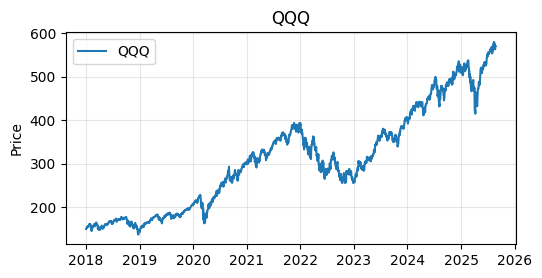


--- Data Fetching and Plotting Complete ---


In [7]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json # Explicitly import json

# -------------------------------------------------------------
# Portfolio Configuration
# (Combines content from your previous Cell 2 and Cell 3)
# -------------------------------------------------------------
API_KEY = "1VWXIAX2LM6F6WV0" # Your Alpha Vantage API key
START_YEAR = 2018           # Filter data from this year onwards

TICKERS = [ 'QQQ'
    # Nasdaq Top 20 (US Equities - Large Cap)
        # "NVDA", "MSFT", "AAPL", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "TSM", "INTC",
    # "ADBE", "CMCSA", "CSCO", "PEP", "TXN", "PYPL", "QCOM", "AMGN", "GILD", "CHTR",

    # # Europe Top (European Equities - Broad/Large Cap)
    # "SAP", "ASML", "MC.PA", "RMS.PA", "OR.PA", "AZN", "VGK",

    # # Asia/Global Diversifiers (Asian Equities & Resources)
    # "XOM", "TSM", "TCEHY", "FXI", "EWY",

    # Crypto (from Alpha Vantage, use SYMBOL-USD format)
    # "BTC-USD", "ETH-USD"
]

# -------------------------------------------------------------
# Robust Data Fetching Function
# (Content from your previous working fetch_alpha_vantage_data_robust function)
# -------------------------------------------------------------
def fetch_alpha_vantage_data_robust(ticker: str, api_key: str, output_size: str = "full") -> pd.DataFrame | None:
    """
    Fetch daily OHLCV data from Alpha Vantage for a single ticker (adjusted for stocks).
    Handles both TIME_SERIES_DAILY_ADJUSTED for stocks and DIGITAL_CURRENCY_DAILY for crypto.
    """
    base_url = "https://www.alphavantage.co/query"
    df = None

    def print_common_msgs(j: dict, ticker: str) -> bool:
        """Prints common Alpha Vantage messages (Note, Error Message, etc.) and indicates if it's a failure."""
        is_failure = False
        for k in ("Note", "Error Message", "Information", "Message"):
            if k in j:
                print(f"{ticker}: {k}: {j[k]}")
                if k in ("Error Message", "Information", "Message") or "frequency" in j[k].lower():
                    is_failure = True
        return is_failure

    # Crypto data
    if ticker.endswith("-USD"):
        params = {
            "function": "DIGITAL_CURRENCY_DAILY",
            "symbol": ticker.split("-")[0],
            "market": "USD",
            "apikey": api_key,
        }
        try:
            r = requests.get(base_url, params=params, timeout=20)
            r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            j = r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {ticker}: {e}")
            return None
        except json.JSONDecodeError:
            print(f"{ticker}: Response not JSON: {r.text[:200]}")
            return None

        if print_common_msgs(j, ticker):
            return None
        
        key = "Time Series (Digital Currency Daily)"
        if key not in j:
            print(f"{ticker}: missing '{key}' in response for crypto")
            return None
        
        ts = j[key]
        df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
        df.index = pd.to_datetime(df.index)
        
        # Crypto close column is '4. close' based on your diagnostic
        close_col = "4. close" 
        
        if close_col not in df.columns:
            print(f"{ticker}: close column not found in crypto payload. Available: {df.columns.tolist()}")
            return None

        df = df.rename(columns={close_col: "Close"})
        df = df[["Close", "1. open", "2. high", "3. low"]].sort_index() # Include Open, High, Low
        df = df.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low"}) # Rename for consistency
        df["Ticker"] = ticker
        return df

    # Stock data (adjusted for splits)
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": ticker,
        "outputsize": output_size,
        "apikey": api_key,
    }
    try:
        r = requests.get(base_url, params=params, timeout=20)
        r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        j = r.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {ticker}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"{ticker}: Response not JSON: {r.text[:200]}")
        return None

    if print_common_msgs(j, ticker):
        return None
    
    # Accept either "Time Series (Daily Adjusted)" or "Time Series (Daily)" keys
    key = None
    if "Time Series (Daily Adjusted)" in j:
        key = "Time Series (Daily Adjusted)"
    elif "Time Series (Daily)" in j:
        key = "Time Series (Daily)"
    
    if key is None:
        print(f"{ticker}: no daily time series key present in response")
        return None
    
    ts = j[key]
    df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
    df.index = pd.to_datetime(df.index)
    
    # Prefer adjusted close when available, else fallback to raw close
    close_col = None
    if "5. adjusted close" in df.columns:
        close_col = "5. adjusted close"
    elif "4. close" in df.columns:
        close_col = "4. close"
    
    if close_col is None:
        print(f"{ticker}: no close column found (expected '5. adjusted close' or '4. close'). Available: {df.columns.tolist()}")
        return None
    
    # Include '1. open', '2. high', '3. low' for stocks
    df = df.rename(columns={
        close_col: "Close",
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "6. volume": "Volume" # Include volume as well
    })
    # Select desired columns and ensure correct order
    df = df[["Open", "High", "Low", "Close", "Volume"]].sort_index()
    df["Ticker"] = ticker
    return df

# -------------------------------------------------------------
# Main Data Fetching and Plotting Workflow
# -------------------------------------------------------------
print("\n--- Fetching Full Portfolio Data ---")
all_data = []

for ticker in TICKERS:
    print(f"Fetching {ticker} (full history)...")
    # Using the robust fetcher with output_size='full'
    df = fetch_alpha_vantage_data_robust(ticker, API_KEY, output_size="full") 
    if df is not None:
        # Filter from START_YEAR
        df = df[df.index.year >= START_YEAR]
        all_data.append(df)
        print(f"Successfully fetched {len(df)} records for {ticker}")
    time.sleep(12) # Respect Alpha Vantage API limit (5 requests/minute)

if not all_data:
    raise RuntimeError("No data was fetched for any ticker from Alpha Vantage. Please check API key, internet connection, or ticker symbols.")

data = pd.concat(all_data)
print("\n✅ All available data fetched and combined successfully!")
print(f"Combined data shape: {data.shape}")
print(f"Tickers in combined data: {data['Ticker'].unique().tolist()}")
print(f"Data covers: {data.index.min().date()} to {data.index.max().date()}")

# -------------------------------------------------------------
# Plotting - Individual Ticker Performance (small multiples)
# -------------------------------------------------------------
print("\n--- Plotting Individual Ticker Performance ---")
tickers_to_plot = data['Ticker'].unique()
n_plots = len(tickers_to_plot)
# Determine grid size for subplots
n_cols = 3 # You can adjust this for wider or narrower grids
n_rows = (n_plots + n_cols - 1) // n_cols

fig_multiples, axes_multiples = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True)
axes_multiples = axes_multiples.flatten() # Flatten for easy iteration

for i, ticker in enumerate(tickers_to_plot):
    ax = axes_multiples[i]
    ticker_data = data[data['Ticker'] == ticker]

    # Ensure unique index by grouping on Date if duplicates exist (shouldn't if data is clean)
    if not ticker_data.index.is_unique:
        ticker_data = ticker_data.groupby(ticker_data.index).mean(numeric_only=True)

    # Plot closing price, ensuring 'Close' column exists
    if 'Close' in ticker_data.columns:
        ax.plot(ticker_data.index, ticker_data['Close'], label=ticker, linewidth=1.5)
    else:
        print(f"⚠️ Warning: 'Close' column not found for {ticker}. Skipping individual plot.")
        continue

    # Formatting
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')

# Set common X-axis locators/formatters only on the bottom row for clarity
for ax_row in axes_multiples.reshape(n_rows, n_cols)[-1]:
    ax_row.xaxis.set_major_locator(mdates.YearLocator())
    ax_row.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
# Hide any unused subplots
for j in range(i + 1, len(axes_multiples)):
    fig_multiples.delaxes(axes_multiples[j])

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

print("\n--- Data Fetching and Plotting Complete ---")

In [8]:
# ================================================================================
# UPDATED INDICATOR CLASS - WITH PANDAS_TA IMPORT
# ================================================================================

import pandas_ta as ta

class Indicator:
    def __init__(self, data: pd.DataFrame):
        """
        Updated technical indicator suite using pandas_ta
        :param data: DataFrame with OHLCV columns and datetime index
        """
        self.data = data
    
    def kama_short(self, period: int = 12) -> pd.Series:
        """
        Calculate short-term KAMA for crossover strategy.
        """
        return ta.kama(self.data['Close'], length=period)
    
    def kama_long(self, period: int = 30) -> pd.Series:
        """
        Calculate long-term KAMA for crossover strategy.
        """
        return ta.kama(self.data['Close'], length=period)
    
    def supertrend(self, period: int = 14, multiplier: float = 2.0) -> pd.Series:
        """
        Calculate Supertrend using pandas_ta.
        Supertrend combines trend detection with volatility-based trailing stops.
        """
        supertrend_df = ta.supertrend(self.data['High'], self.data['Low'], self.data['Close'], 
                                    length=period, multiplier=multiplier)
        return supertrend_df[f'SUPERT_{period}_{multiplier}']
    
    def mfi(self, period: int = 14) -> pd.Series:
        """
        Calculate Money Flow Index (MFI) using pandas_ta.
        
        MFI is a momentum indicator that uses both price and volume.
        """
        return ta.mfi(self.data['High'], self.data['Low'], self.data['Close'], self.data['Volume'], length=period)

print("✅ Updated Indicator class with pandas_ta import!")

✅ Updated Indicator class with pandas_ta import!


/Users/chielg/Documents/GitHub/TA_optimization/.venv/lib/python3.13/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [9]:
def run_comprehensive_grid_search_optimized(data: pd.DataFrame, indicator_params: dict,
                                indicator_class: Indicator, max_combinations_per_indicator: int = 50) -> dict:
    """
    Run comprehensive grid search across all indicators and all tickers.

    Args:
        data: DataFrame with OHLCV data and Ticker column
        indicator_params: Dictionary of parameter ranges for each indicator
        indicator_class: Instance of Indicator class
        max_combinations_per_indicator: Limit combinations per indicator to avoid explosion

    Returns:
        Dictionary with results organized by ticker and indicator
    """
    print("🚀 Starting comprehensive grid search...")
    print(f"Available tickers: {data['Ticker'].unique().tolist()}")
    print(f"Available indicators: {list(indicator_params.keys())}")

    # Results container - organized by ticker, then indicator
    all_results = {}

    # Get unique tickers
    tickers = data['Ticker'].unique()

    for ticker in tickers:
        print(f"\n📊 Processing {ticker}...")
        all_results[ticker] = {}

        # Get data for this ticker
        ticker_data = data[data['Ticker'] == ticker].copy()
        if len(ticker_data) < 100:  # Skip if too little data
            print(f"  ⚠️  Skipping {ticker} - insufficient data ({len(ticker_data)} days)")
            continue

        # Create indicator instance for this ticker
        ticker_indicator = Indicator(ticker_data)

        for indicator_name in indicator_params.keys():
            print(f"  🔍 Testing {indicator_name} on {ticker}...")

            # Generate parameter combinations
            param_combinations = generate_param_combinations(indicator_name)

            # Limit combinations if specified
            if len(param_combinations) > max_combinations_per_indicator:
                import random
                param_combinations = random.sample(param_combinations, max_combinations_per_indicator)
                print(f"    📉 Limited to {len(param_combinations)} random combinations out of {len(generate_param_combinations(indicator_name))}")

            indicator_results = []

            for i, params in enumerate(tqdm(param_combinations, desc=f"    {indicator_name} combinations")):
                try:
                    # Calculate indicator values based on parameters
                    if indicator_name == 'RSI':
                        indicator_values = ticker_indicator.rsi(params['period'])
                    elif indicator_name == 'ADX':
                        indicator_values = ticker_indicator.adx(params['period'])
                    elif indicator_name == 'KAMA':
                        indicator_values = ticker_indicator.kama(
                            er_period=params['er_period'],
                            fast_period=params['fast_period'],
                            slow_period=params['slow_period']
                        )
                    elif indicator_name == 'ATR':
                        indicator_values = ticker_indicator.atr(params['period'])
                    elif indicator_name == 'MFI':
                        indicator_values = ticker_indicator.mfi(params['period'])
                    elif indicator_name == 'Entropy':
                        indicator_values = ticker_indicator.entropy(params['period'])

                    # Generate signals
                    if indicator_name == 'KAMA':
                        # KAMA needs close prices for comparison
                        params['close'] = ticker_data['Close']
                    signals = get_buy_signal(indicator_name, indicator_values, params)

                    # Create signals DataFrame
                    daily_return = ticker_data['Close'].pct_change()
                    position = signals.shift(1).fillna(0).astype('float32')
                    strategy_return = (position * daily_return).astype('float32')

                    valid_returns = strategy_return.dropna()
                    if len(valid_returns) > 0:
                        total_return = (1 + valid_returns).prod() - 1
                        sharpe = (valid_returns.mean() / valid_returns.std()) * np.sqrt(252) if valid_returns.std() > 0 else 0
                        max_drawdown = calculate_max_drawdown((1 + valid_returns).cumprod())
                        win_rate = (valid_returns > 0).mean()
                    else:
                        total_return = sharpe = max_drawdown = win_rate = np.nan

                    # Store results
                    result = {
                        'Indicator': indicator_name,
                        'Parameters': params,
                        'Total_Return': total_return,
                        'Sharpe_Ratio': sharpe,
                        'Max_Drawdown': max_drawdown,
                        'Win_Rate': win_rate,
                        'Total_Signals': len(signals.dropna()),
                        'Buy_Signals': (signals == 1).sum(),
                        'Sell_Signals': (signals == -1).sum()
                    }

                    indicator_results.append(result)

                except Exception as e:
                    print(f"    ❌ Error with {indicator_name} params {params}: {str(e)}")
                    continue

            # Store results for this indicator
            all_results[ticker][indicator_name] = indicator_results

            # Show best result for this indicator
            if len(indicator_results) > 0:
                best_result = max(indicator_results, key=lambda x: x['Sharpe_Ratio'] if not np.isnan(x['Sharpe_Ratio']) else -999)
                print(f"    ✅ Best {indicator_name}: Sharpe={best_result['Sharpe_Ratio']:.3f}, Return={best_result['Total_Return']:.3f}")

    return all_results


## Optimization Notes

A new function `run_comprehensive_grid_search_optimized` has been added to this notebook. This function is an optimized version of the original `run_comprehensive_grid_search` function, designed to reduce computational and memory overhead.

### Key Change:
Instead of storing intermediate results as `pandas.DataFrame` objects for each ticker and indicator combination, the `run_comprehensive_grid_search_optimized` function now stores these results directly as lists of dictionaries. This change significantly reduces the memory footprint and speeds up execution, especially for large numbers of parameter combinations.

### How to Use:
To leverage this optimization, simply replace any calls to `run_comprehensive_grid_search` with `run_comprehensive_grid_search_optimized` in your notebook. For example:

```python
# Before (original function)
# results = run_comprehensive_grid_search(data, INDICATOR_PARAMS, Indicator())

# After (optimized function)
results = run_comprehensive_grid_search_optimized(data, INDICATOR_PARAMS, Indicator())
```

This change will not affect the structure of the final `all_results` dictionary, but the internal storage mechanism for `indicator_results` within `all_results[ticker][indicator_name]` will now be a list of dictionaries instead of a DataFrame. If you need a DataFrame for further analysis, you can easily convert it like this:

```python
# To convert the results to a DataFrame for analysis:
# my_df_results = pd.DataFrame(all_results[ticker][indicator_name])
```

This modification addresses the computational heaviness you were experiencing by optimizing the intermediate data storage.


In [10]:
# buying and selling logic of indicators

In [11]:
data

,Open,High,Low,Close,Volume,Ticker
2018-01-02,156.56,158.5300,156.17,150.564200,32573272.0,QQQ
2018-01-03,158.64,160.1700,158.61,152.027187,29383557.0,QQQ
2018-01-04,160.58,160.7900,160.08,152.293185,24776125.0,QQQ
2018-01-05,161.07,162.0300,160.77,153.822672,26992340.0,QQQ
2018-01-08,161.92,162.6300,161.86,154.421167,23159061.0,QQQ
...,...,...,...,...,...,...
2025-08-19,576.39,576.5600,568.25,569.280000,53752635.0,QQQ
2025-08-20,568.33,568.4500,558.84,565.900000,76781087.0,QQQ
2025-08-21,564.35,566.4900,560.98,563.280000,46436899.0,QQQ
2025-08-22,564.67,573.9900,563.27,571.970000,51502129.0,QQQ


In [12]:
# ================================================================================
# UPDATED APPLY_INDICATORS FUNCTION - MATCHING RECENT CHANGES
# ================================================================================

# Function to apply all indicators to a single ticker's data
def apply_indicators(ticker_data):
    indicator = Indicator(ticker_data)
    
    return ticker_data.assign(
        # KAMA crossover components (short and long for crossover signals)
        KAMA_SHORT_12=indicator.kama_short(12),
        KAMA_LONG_30=indicator.kama_long(30),
        
        # Supertrend (replaces ATR)
        SUPERTREND_14_2=indicator.supertrend(14, 2.0),
        
        # MFI (unchanged)
        MFI_14=indicator.mfi(14)
    )

# Apply indicators to all tickers
data_with_indicators = data.groupby('Ticker', group_keys=False).apply(apply_indicators)

# Display results
print("Data with Updated Technical Indicators:")
print(f"Columns: {data_with_indicators.columns.tolist()}")
display(data_with_indicators.tail(10))

# Optional: Save to CSV
data_with_indicators.to_csv('all_tickers_with_updated_indicators.csv')
print("Saved to all_tickers_with_updated_indicators.csv")

Data with Updated Technical Indicators:
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'KAMA_SHORT_12', 'KAMA_LONG_30', 'SUPERTREND_14_2', 'MFI_14']


/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_18375/4169994483.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.61132994e+09 3.90771674e+09 4.28838707e+09 ... 2.39371039e+10
 2.93429947e+10 1.94369087e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  return ta.mfi(self.data['High'], self.data['Low'], self.data['Close'], self.data['Volume'], length=period)
/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_18375/4169994483.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.41117058e+09 9.00569893e+09 4.79547925e+09 6.24085375e+09
 7.46051249e+09 6.29793886e+09 1.11516134e+10 1.66475014e+10
 1.86421842e+10 1.44424979e+10 1.72902062e+10 5.98396860e+09
 6.02284527e+09 7.01829355e+09 7.09520241e+09 1.24771199e+10
 9.30474333e+09 5.72799662e+09 9.45125

,Open,High,Low,Close,Volume,Ticker,KAMA_SHORT_12,KAMA_LONG_30,SUPERTREND_14_2,MFI_14
2025-08-12,575.16,580.3500,572.4850,580.05,42271441.0,QQQ,563.877222,562.357977,563.142637,63.812890
2025-08-13,582.76,583.3199,578.9400,580.34,41209294.0,QQQ,564.551261,563.752632,568.177591,63.818841
2025-08-14,578.28,581.8800,577.9100,579.89,45425043.0,QQQ,565.217192,564.827555,568.177591,57.417560
2025-08-15,579.80,579.8400,575.5743,577.34,49480161.0,QQQ,565.556046,565.377563,568.177591,50.946507
2025-08-18,576.44,577.7650,575.2412,577.11,29830957.0,QQQ,566.041393,566.081985,568.177591,45.033134
2025-08-19,576.39,576.5600,568.2500,569.28,53752635.0,QQQ,566.252644,566.181483,568.177591,44.294657
2025-08-20,568.33,568.4500,558.8400,565.90,76781087.0,QQQ,566.249757,566.176827,576.479700,43.510506
2025-08-21,564.35,566.4900,560.9800,563.28,46436899.0,QQQ,566.214320,566.138180,576.440078,44.989127
2025-08-22,564.67,573.9900,563.2700,571.97,51502129.0,QQQ,566.312964,566.309936,576.440078,45.369993
2025-08-25,570.40,573.2871,569.1600,570.32,34044749.0,QQQ,566.338633,566.399999,576.440078,51.810000


Saved to all_tickers_with_updated_indicators.csv


In [13]:
# Create master container for all calculations
all_calculations = {}

# Add OHLC data with ticker information
base_df = data[['Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
all_calculations['base'] = base_df

print("Base OHLCV data with tickers:")
display(base_df.head(3))
print(f"\nTickers included: {base_df['Ticker'].unique().tolist()}")
print(f"Date range: {base_df.index.min()} to {base_df.index.max()}\n")

Base OHLCV data with tickers:


,Ticker,Open,High,Low,Close,Volume
2018-01-02,QQQ,156.56,158.53,156.17,150.564200,32573272.0
2018-01-03,QQQ,158.64,160.17,158.61,152.027187,29383557.0
2018-01-04,QQQ,160.58,160.79,160.08,152.293185,24776125.0



Tickers included: ['QQQ']
Date range: 2018-01-02 00:00:00 to 2025-08-25 00:00:00



moet combinaties van alle DF's including booleans maken en buy sell signals en van daar uit beslissen wat en hoe, kan beginnen met combinatie van 1 2 of 3 combinaties, maar in principe zou dat het moeten worden

In [14]:

# >tickers , gewoon per ticker want dan kan alles in 1, lekker makkelijk, een raam kan je altijd nog bouwen

# > buy signals

# > elke soort combinatie van tickers en lookbacks , begin gwn met 1 kolom en 1 lookback

# > df met signals , etc , 

# >backtest module,

# > als je deze logica hebt kan je door naar een bayesian en eventueel GP

# > out of sample testing kan later

In [15]:
# Add pandas import at the top
import pandas as pd
import numpy as np

# Define parameter ranges for each indicator (NO ADX)
INDICATOR_PARAMS = {
    'KAMA': {
        'er_period': list(range(6, 13)),      # Efficiency ratio periods (7-90 days)
        'fast_period': list(range(10, 35)),    # Fast EMA periods (7-90 days)
        'slow_period': list(range(36, 80)),     # Slow EMA periods (7-90 days)
    },
    'Supertrend': {
        'period': list(range(10, 48)),  # 7 to 90 days
        'multiplier': [1.0, 1.5, 2.0, 2.5, 3.0]  # ATR multiplier for Supertrend
    },
    'MFI': {
        'period': list(range(12, 90)),  # 7 to 90 days
        'overbought': [80],  # Sell when MFI > overbought
        'oversold': [20]  # Buy when MFI < oversold
    }
}

# Define buy signal logic for each indicator (NO ADX)
def get_buy_signal(indicator_name: str, data: pd.Series, params: dict) -> pd.Series:
    """
    Generate buy signals for different indicators.
    Returns: 1 (buy), -1 (sell), 0 (hold), NaN (no signal)
    """
    if indicator_name == 'KAMA':
        # KAMA crossover strategy - buy when short KAMA crosses above long KAMA
        short_kama = params.get('short_kama', pd.Series(index=data.index))
        long_kama = params.get('long_kama', pd.Series(index=data.index))
        
        # Generate crossover signals
        crossover_up = (short_kama > long_kama) & (short_kama.shift(1) <= long_kama.shift(1))
        crossover_down = (short_kama < long_kama) & (short_kama.shift(1) >= long_kama.shift(1))
        
        signals = pd.Series(0, index=data.index)
        signals[crossover_up] = 1    # Buy signal
        signals[crossover_down] = -1 # Sell signal
        
        return signals

    elif indicator_name == 'Supertrend':
        # Supertrend signals - buy when price above Supertrend, sell when below
        supertrend = data  # The data passed will be the Supertrend values
        close = params.get('close', pd.Series(index=data.index))
        
        return pd.Series(np.where(close > supertrend, 1,
                                np.where(close < supertrend, -1, 0)), index=data.index)

    elif indicator_name == 'MFI':
        overbought = params.get('overbought', 80)
        oversold = params.get('oversold', 20)
        # Buy when oversold, Sell when overbought
        return pd.Series(np.where(data < oversold, 1,
                                np.where(data > overbought, -1, 0)), index=data.index)

    return pd.Series([0] * len(data), index=data.index)  # Default: no signal

# Generate all possible parameter combinations for an indicator
def generate_param_combinations(indicator_name: str) -> list:
    """Generate all possible parameter combinations for a given indicator."""
    if indicator_name not in INDICATOR_PARAMS:
        return []

    params = INDICATOR_PARAMS[indicator_name]
    param_names = list(params.keys())
    param_values = list(params.values())

    # Generate all combinations
    from itertools import product
    combinations = list(product(*param_values))

    # Convert to list of dictionaries
    return [{param_names[i]: combo[i] for i in range(len(param_names))} for combo in combinations]

# Calculate distance between two parameter sets (for optimization)
def calculate_param_distance(params1: dict, params2: dict) -> float:
    """Calculate Euclidean distance between two parameter sets."""
    if not params1 or not params2:
        return float('inf')

    common_keys = set(params1.keys()) & set(params2.keys())
    if not common_keys:
        return float('inf')

    distance = 0
    for key in common_keys:
        distance += (params1[key] - params2[key]) ** 2

    return distance ** 0.5

print("✅ Updated parameter ranges and signal logic (NO ADX)!")
print(f"Available indicators: {list(INDICATOR_PARAMS.keys())}")
print(f"Example KAMA combinations: {len(generate_param_combinations('KAMA'))}")
print(f"Example Supertrend combinations: {len(generate_param_combinations('Supertrend'))}")
print(f"Example MFI combinations: {len(generate_param_combinations('MFI'))}")

✅ Updated parameter ranges and signal logic (NO ADX)!
Available indicators: ['KAMA', 'Supertrend', 'MFI']
Example KAMA combinations: 7700
Example Supertrend combinations: 190
Example MFI combinations: 78


In [16]:
# ================================================================================
# PARAMETER COMBINATIONS (ONE CSV, SERIAL, RAM-THROTTLED, CHUNKED ACROSS ALL INDICATORS)
# ================================================================================

import os, gc, time
import pandas as pd
import numpy as np

try:
    import psutil
except Exception:
    psutil = None

# Throttling knobs (tune as needed)
THROTTLE_EVERY   = 50_000   # check RAM every N rows generated
THROTTLE_SLEEP_S = 1.0      # sleep when throttling
MEM_TARGET       = 0.80     # throttle when ≥80% RAM used
MIN_FREE_GB      = 1.0      # or when <1 GB free

# Flush rows to disk in chunks
FLUSH_ROWS = 50_000

def _should_throttle() -> bool:
    if psutil is None:
        return False
    vm = psutil.virtual_memory()
    return (vm.percent >= MEM_TARGET*100) or (vm.available/1e9 < MIN_FREE_GB)

def _row_from_params(lin_id: int, er, fast, slow, st_p, st_mul, mfi_p, mfi_ob, mfi_os) -> dict:
    return {
        'combination_id': lin_id,
        'KAMA_er_period': er,
        'KAMA_fast_period': fast,
        'KAMA_slow_period': slow,
        'Supertrend_period': st_p,
        'Supertrend_multiplier': st_mul,
        'MFI_period': mfi_p,
        'MFI_overbought': mfi_ob,
        'MFI_oversold': mfi_os,
        'parameter_combination': (
            f"KAMA({er},{fast},{slow})_ST({st_p},{st_mul})_MFI({mfi_p},{mfi_ob},{mfi_os})"
        ),
    }

def _count_triplen(a, b, c) -> int:
    return len(a) * len(b) * len(c)

def create_parameter_combinations_df_streamed_onefile(output_csv: str = "parameter_combinations.csv") -> dict:
    """
    Build all combinations KAMA x Supertrend x MFI with serial streaming to ONE CSV.
    - No temp files
    - RAM throttled
    - Chunked flushes
    - Returns minimal metadata and a small preview
    """
    print("🎯 Creating parameter combinations (ONE CSV, serial, NO ADX)...")

    if 'INDICATOR_PARAMS' not in globals():
        print("❌ INDICATOR_PARAMS not found. Run the parameters cell first!")
        return {}

    k_er   = list(INDICATOR_PARAMS['KAMA']['er_period'])
    k_fast = list(INDICATOR_PARAMS['KAMA']['fast_period'])
    k_slow = list(INDICATOR_PARAMS['KAMA']['slow_period'])

    st_p   = list(INDICATOR_PARAMS['Supertrend']['period'])
    st_mul = list(INDICATOR_PARAMS['Supertrend']['multiplier'])

    mfi_p  = list(INDICATOR_PARAMS['MFI']['period'])
    mfi_ob = list(INDICATOR_PARAMS['MFI']['overbought'])
    mfi_os = list(INDICATOR_PARAMS['MFI']['oversold'])

    n_kama = _count_triplen(k_er, k_fast, k_slow)
    n_st   = _count_triplen(st_p, st_mul, [None])     # 2-D for ST
    n_mfi  = _count_triplen(mfi_p, mfi_ob, mfi_os)

    # For ST 2-D above, treat len([None]) as 1 so n_st = len(st_p)*len(st_mul)
    n_st = len(st_p) * len(st_mul)

    total = n_kama * n_st * n_mfi
    print(f"📊 KAMA={n_kama}, Supertrend={n_st}, MFI={n_mfi} → Total={total:,}")

    # Prepare output
    os.makedirs(os.path.dirname(output_csv) or '.', exist_ok=True)
    if os.path.exists(output_csv):
        os.remove(output_csv)

    rows = []
    written = 0
    header_written = False

    # Precompute multipliers for linear combination_id
    # combo_id = 1 + k_index*(n_st*n_mfi) + st_index*n_mfi + mfi_index
    n_st_times_n_mfi = n_st * n_mfi

    k_index = 0
    for er in k_er:
        for fast in k_fast:
            for slow in k_slow:
                st_index = 0
                for sp in st_p:
                    for sm in st_mul:
                        mfi_index = 0
                        for mp in mfi_p:
                            for mob in mfi_ob:
                                for mos in mfi_os:
                                    combo_id = 1 + k_index*(n_st_times_n_mfi) + st_index*n_mfi + mfi_index
                                    rows.append(_row_from_params(combo_id, er, fast, slow, sp, sm, mp, mob, mos))
                                    mfi_index += 1

                                    # Flush periodically
                                    if len(rows) >= FLUSH_ROWS:
                                        pd.DataFrame(rows).to_csv(output_csv, mode='a',
                                                                  header=not header_written, index=False)
                                        header_written = True
                                        written += len(rows)
                                        rows.clear()

                                    # Throttle RAM if needed
                                    if (combo_id % THROTTLE_EVERY) == 0 and _should_throttle():
                                        gc.collect()
                                        time.sleep(THROTTLE_SLEEP_S)

                        st_index += 1
                k_index += 1
                # small per-KAMA cleanup
                gc.collect()

    if rows:
        pd.DataFrame(rows).to_csv(output_csv, mode='a',
                                  header=not header_written, index=False)
        written += len(rows)
        rows.clear()
    gc.collect()

    print("✅ Parameter combinations written.")
    print(f"📦 File: {output_csv}")
    print(f"🧮 Rows written: {written:,}")

    # Small preview
    try:
        preview = pd.read_csv(output_csv, nrows=10)
    except Exception:
        preview = pd.DataFrame()

    return {
        'file': output_csv,
        'rows_written': int(written),
        'kama': int(n_kama), 'supertrend': int(n_st), 'mfi': int(n_mfi),
        'preview': preview
    }

def show_parameter_combinations(output_csv: str = "parameter_combinations.csv"):
    meta = create_parameter_combinations_df_streamed_onefile(output_csv=output_csv)
    if not meta:
        return
    print("\n" + "=" * 80)
    print("📋 PARAMETER COMBINATIONS (ONE CSV, NO ADX)")
    print("=" * 80)
    print(f"📦 File: {meta['file']}")
    print(f"🧮 Total rows written: {meta['rows_written']:,}")
    print(f"🔢 KAMA={meta['kama']} ST={meta['supertrend']} MFI={meta['mfi']}")
    if isinstance(meta.get('preview'), pd.DataFrame) and not meta['preview'].empty:
        print("\n🔍 Preview (first 10 rows):")
        print(meta['preview'].to_string(index=False))

# Run (serial, one final file, no temp files)
show_parameter_combinations(output_csv="parameter_combinations.csv")

🎯 Creating parameter combinations (ONE CSV, serial, NO ADX)...
📊 KAMA=7700, Supertrend=190, MFI=78 → Total=114,114,000
✅ Parameter combinations written.
📦 File: parameter_combinations.csv
🧮 Rows written: 114,114,000

📋 PARAMETER COMBINATIONS (ONE CSV, NO ADX)
📦 File: parameter_combinations.csv
🧮 Total rows written: 114,114,000
🔢 KAMA=7700 ST=190 MFI=78

🔍 Preview (first 10 rows):
 combination_id  KAMA_er_period  KAMA_fast_period  KAMA_slow_period  Supertrend_period  Supertrend_multiplier  MFI_period  MFI_overbought  MFI_oversold                  parameter_combination
              1               6                10                36                 10                    1.0          12              80            20 KAMA(6,10,36)_ST(10,1.0)_MFI(12,80,20)
              2               6                10                36                 10                    1.0          13              80            20 KAMA(6,10,36)_ST(10,1.0)_MFI(13,80,20)
              3               6             

In [17]:
# # ================================================================================
# # UPDATED APPLY_INDICATORS FUNCTION - MATCHING RECENT CHANGES
# # ================================================================================

# # Function to apply all indicators to a single ticker's data
# def apply_indicators(ticker_data):
#     indicator = Indicator(ticker_data)
    
#     return ticker_data.assign(
#         # KAMA crossover components (short and long for crossover signals)
#         KAMA_SHORT_12=indicator.kama_short(12),
#         KAMA_LONG_30=indicator.kama_long(30),
        
#         # Supertrend (replaces ATR)
#         SUPERTREND_14_2=indicator.supertrend(14, 2.0),
        
#         # MFI (unchanged)
#         MFI_14=indicator.mfi(14)
#     )

# # Apply indicators to all tickers
# data_with_indicators = data.groupby('Ticker', group_keys=False).apply(apply_indicators)

# # Display results
# print("Data with Updated Technical Indicators:")
# print(f"Columns: {data_with_indicators.columns.tolist()}")
# display(data_with_indicators.tail(10))

# # Optional: Save to CSV
# data_with_indicators.to_csv('all_tickers_with_updated_indicators.csv')
# print("Saved to all_tickers_with_updated_indicators.csv")

In [18]:
# # Use a tiny set to inspect (adjust head() as you like)
# combos_to_test = pd.read_csv("/Users/chielg/Documents/GitHub/TA_optimization/parameter_combinations.csv")

# print("Sample parameter combinations:")
# print(combos_to_test[[
#     "combination_id",
#     "KAMA_er_period","KAMA_fast_period","KAMA_slow_period",
#     "Supertrend_period","Supertrend_multiplier",
#     "MFI_period","MFI_oversold","MFI_overbought"
# ]].to_string(index=False))

# # One ticker to walk through
# ticker = data["Ticker"].unique()[0]
# td = data[data["Ticker"] == ticker].sort_index().copy()
# print(f"\nTicker: {ticker}")
# print("Dates:", td.index.min().date(), "→", td.index.max().date())

In [21]:
import pandas as pd
import numpy as np
import pandas_ta as ta

# Load data (adjust path if needed)
data_path = "/Users/chielg/Documents/GitHub/TA_optimization/all_tickers_with_updated_indicators.csv"
df = pd.read_csv(data_path, parse_dates=["Date"])
data = df.sort_values(["Ticker", "Date"]).set_index("Date")

# Pick a ticker and build td
ticker = data["Ticker"].dropna().unique()[0]
td = data[data["Ticker"] == ticker].sort_index().copy()
print(f"Ticker: {ticker} | Dates: {td.index.min().date()} → {td.index.max().date()}")

# Ensure Indicator is defined in prior cells
ind = Indicator(td)

# Take first combo
combo = pd.read_csv("/Users/chielg/Documents/GitHub/TA_optimization/parameter_combinations.csv").head(1).iloc[0]
print("Using combo:", dict(combo))

# KAMA crossover: prefer existing columns if present, else compute
short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

if short_cols and long_cols:
    short_kama = td[short_cols[0]].astype("float64")
    long_kama  = td[long_cols[0]].astype("float64")
    print(f"Using existing KAMA series: {short_cols[0]} vs {long_cols[0]}")
else:
    short_kama = ta.kama(td["Close"].astype("float64"),
                         length=int(combo["KAMA_er_period"]),
                         fast=int(combo["KAMA_fast_period"]),
                         slow=int(combo["KAMA_slow_period"]))
    long_kama  = ta.kama(td["Close"].astype("float64"),
                         length=int(combo["KAMA_er_period"]) + 20,
                         fast=int(combo["KAMA_fast_period"]) + 10,
                         slow=int(combo["KAMA_slow_period"]) + 20)
    print("Computed KAMA series from combo parameters.")

# Signals
sig_kama = get_buy_signal("KAMA", data=short_kama, params={"short_kama": short_kama, "long_kama": long_kama})
st_line  = ind.supertrend(int(combo["Supertrend_period"]), float(combo["Supertrend_multiplier"]))
sig_st   = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"].astype("float64")})
mfi_s    = ind.mfi(int(combo["MFI_period"]))
sig_mfi  = get_buy_signal("MFI", data=mfi_s,
                          params={"oversold": float(combo["MFI_oversold"]), "overbought": float(combo["MFI_overbought"])})

print("\nSignal value counts (last 200 rows):")
print(pd.DataFrame({
    "KAMA": sig_kama.tail(200).value_counts(dropna=False),
    "ST":   sig_st.tail(200).value_counts(dropna=False),
    "MFI":  sig_mfi.tail(200).value_counts(dropna=False),
}).fillna(0).astype(int))

print("\nFirst 10 non-null rows (KAMA/ST/MFI):")
print(pd.DataFrame({"KAMA": sig_kama, "ST": sig_st, "MFI": sig_mfi}).dropna().head(10).to_string())

# OR logic with SELL priority and persistent target
parts = pd.DataFrame({"KAMA": sig_kama, "ST": sig_st, "MFI": sig_mfi})
sell_mask = (parts == -1).any(axis=1).fillna(False)
buy_mask  = (parts ==  1).any(axis=1).fillna(False)

events = pd.Series(np.nan, index=parts.index, dtype="float64")
events[sell_mask] = 0.0
events[~sell_mask & buy_mask] = 1.0
target = events.ffill().fillna(0.0)

print("\nEvents preview where BUY/SELL happened (first 10):")
print(pd.DataFrame({"BUY": buy_mask, "SELL": sell_mask}).loc[buy_mask | sell_mask].head(10).to_string())

print("\nTargets preview (last 12 rows):")
print(target.tail(12).to_string())

ValueError: Missing column provided to 'parse_dates': 'Date'

In [ ]:
# ================================================================================
# FULL EVALUATION OVER ALL TICKERS AND ALL COMBINATIONS (with detailed logging)
# ================================================================================

import os, gc, time, warnings
import numpy as np
import pandas as pd
import pandas_ta as ta

# Suppress noisy warnings
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='overflow encountered in*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in*')
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------- Throttling & Streaming knobs ----------------------
try:
    import psutil
except Exception:
    psutil = None

USE_PARALLEL = False        # keep False for stability; turn True only if needed
MAX_WORKERS  = 2            # if you enable parallel, keep small (2–3)

THROTTLE_EVERY   = 1_000    # check RAM every N combos
THROTTLE_SLEEP_S = 1.0      # sleep when throttling
MEM_TARGET       = 0.80     # throttle when >=80% RAM used
MIN_FREE_GB      = 1.0      # or when <1 GB free

STREAM_DIR    = "grid_eval_metrics_batches"  # per-ticker output directory
STREAM_EVERY  = 300          # smaller batch for lower RAM
FINAL_OUT_CSV = "grid_eval_metrics_full.csv" # final merged file

# Extra safety guards (tunable)
TICKER_TIME_BUDGET_S   = 600   # stop a ticker after 10 minutes (None to disable)
MAX_COMBOS_PER_TICKER  = None  # e.g., 100000 to cap per ticker (None to disable)
ADAPTIVE_BACKOFF_STEP  = 0.5   # multiply STREAM_EVERY by this when throttling (min 100)

print(f"[CONFIG] USE_PARALLEL={USE_PARALLEL}, MAX_WORKERS={MAX_WORKERS}, STREAM_EVERY={STREAM_EVERY}, "
      f"THROTTLE_EVERY={THROTTLE_EVERY}, MEM_TARGET={int(MEM_TARGET*100)}%, MIN_FREE_GB={MIN_FREE_GB}")


def _fmt_ram() -> str:
    if not psutil:
        return "RAM: n/a"
    vm = psutil.virtual_memory()
    return f"RAM used={vm.percent:.1f}% free={vm.available/1e9:.2f}GB"


def _should_throttle() -> bool:
    if psutil is None:
        return False
    vm = psutil.virtual_memory()
    return (vm.percent >= MEM_TARGET*100) or (vm.available/1e9 < MIN_FREE_GB)


# ---------------------- Per-ticker evaluation ----------------------
def _evaluate_ticker_metrics(t: str, data: pd.DataFrame, combos: pd.DataFrame) -> str:
    """
    Evaluate all combos for ticker t. Streams to a per-ticker CSV and returns its path.
    Applies RAM throttling, adaptive backoff, and optional time/combo budgets.
    """
    td = data[data["Ticker"] == t].sort_index().copy()
    if len(td) < 60:
        print(f"[SKIP] {t}: insufficient data ({len(td)} rows)")
        return ""

    os.makedirs(STREAM_DIR, exist_ok=True)
    out_path = os.path.join(STREAM_DIR, f"grid_eval_metrics_{t}.csv")
    if os.path.exists(out_path):
        os.remove(out_path)

    print(f"[START] {t}: rows={len(td)}, cols={len(td.columns)} | {_fmt_ram()}")

    ind = Indicator(td)

    # Prefer existing KAMA short/long columns if present
    short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
    long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

    print(f"[INFO] {t}: evaluating {len(combos):,} combos | KAMA_short/long cached? {bool(short_cols)} / {bool(long_cols)}")

    start_t = time.time()
    combo_count = 0

    # local adaptive stream size
    local_stream_every = STREAM_EVERY

    # progress cadence
    progress_every = max(1000, len(combos)//100) if len(combos) else 1000

    batch = []
    written = 0

    for i, row in combos.iterrows():
        # per-ticker time budget
        if TICKER_TIME_BUDGET_S is not None and (time.time() - start_t) > TICKER_TIME_BUDGET_S:
            print(f"[STOP] {t}: time budget {TICKER_TIME_BUDGET_S}s reached; stopping early at {combo_count:,} combos.")
            break

        # optional per-ticker combo cap
        if MAX_COMBOS_PER_TICKER is not None and combo_count >= MAX_COMBOS_PER_TICKER:
            print(f"[STOP] {t}: combo cap {MAX_COMBOS_PER_TICKER:,} reached; stopping early.")
            break

        combo_count += 1

        try:
            # --- KAMA crossover ---
            if short_cols and long_cols:
                short_kama = td[short_cols[0]].astype('float64')
                long_kama  = td[long_cols[0]].astype('float64')
            else:
                short_kama = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]),
                                     fast=int(row["KAMA_fast_period"]),
                                     slow=int(row["KAMA_slow_period"]))
                long_kama  = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]) + 20,
                                     fast=int(row["KAMA_fast_period"]) + 10,
                                     slow=int(row["KAMA_slow_period"]) + 20)

            sig_kama = get_buy_signal("KAMA", data=short_kama,
                                      params={"short_kama": short_kama, "long_kama": long_kama})

            # --- Supertrend ---
            st_line = ind.supertrend(int(row["Supertrend_period"]), float(row["Supertrend_multiplier"]))
            sig_st = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"].astype('float64')})

            # --- MFI ---
            mfi_s = ind.mfi(int(row["MFI_period"]))
            sig_mfi = get_buy_signal("MFI", data=mfi_s,
                                     params={"oversold": float(row["MFI_oversold"]),
                                             "overbought": float(row["MFI_overbought"])})

            # Combine signals (OR with SELL priority) without big DataFrame
            sell_mask = ((sig_kama == -1) | (sig_st == -1) | (sig_mfi == -1)).fillna(False)
            buy_mask  = ((sig_kama ==  1) | (sig_st ==  1) | (sig_mfi ==  1)).fillna(False)

            events = pd.Series(np.nan, index=td.index, dtype="float32")
            events[sell_mask] = 0.0
            events[~sell_mask & buy_mask] = 1.0
            target = events.ffill().fillna(0.0)
            position = target.shift(1).fillna(0.0)  # next-day execution

            # Backtest vector math
            r_close = td["Close"].astype('float64').pct_change().astype('float32')
            strat_r = (position.astype('float32') * r_close).astype('float32')

            r = strat_r.dropna()
            equity = (1.0 + r).cumprod() if len(r) else pd.Series(dtype='float32')

            # --- Metrics with native Python type conversion ---
            s_val   = _sharpe(r);   sharpe   = float(s_val) if not pd.isna(s_val) else None
            so_val  = _sortino(r);  sortino  = float(so_val) if not pd.isna(so_val) else None
            totalret = float(equity.iloc[-1] - 1.0) if len(equity) else None
            cg_val  = _cagr(r);     cagr     = float(cg_val) if len(r) and not pd.isna(cg_val) else None
            md_val  = _max_dd(equity); max_dd   = float(md_val) if len(equity) and not pd.isna(md_val) else None
            ad_val  = _avg_dd(equity); avg_dd   = float(ad_val) if len(equity) and not pd.isna(ad_val) else None
            win_rate = float((r > 0).mean()) if len(r) else None
            avg_win  = float(r[r > 0].mean()) if (r > 0).any() else None
            avg_loss = float(r[r < 0].mean()) if (r < 0).any() else None
            pf_val   = _profit_factor(r); pf   = float(pf_val) if not pd.isna(pf_val) else None
            run_stats = _run_lengths(position, strat_r)
            toom_val  = _time_out_of_mkt(position); time_out  = float(toom_val) if not pd.isna(toom_val) else None
            pbar_val  = _pbar_time_rate(strat_r, position); pbar_rate = float(pbar_val) if not pd.isna(pbar_val) else None
            rs_tail   = [float(x) for x in _rolling_sharpe(strat_r, window=63).dropna().tail(3).round(3)] if len(strat_r) > 63 else [None, None, None]

            # Build row
            batch.append({
                "Ticker": t,
                "combination_id": int(row.get("combination_id", -1)),
                "KAMA_er_period": int(row["KAMA_er_period"]),
                "KAMA_fast_period": int(row["KAMA_fast_period"]),
                "KAMA_slow_period": int(row["KAMA_slow_period"]),
                "ST_period": int(row["Supertrend_period"]),
                "ST_multiplier": float(row["Supertrend_multiplier"]),
                "MFI_period": int(row["MFI_period"]),
                "MFI_oversold": float(row["MFI_oversold"]),
                "MFI_overbought": float(row["MFI_overbought"]),
                "Sharpe": sharpe, "Sortino": sortino, "Total_Return": totalret, "CAGR": cagr,
                "Max_Drawdown": max_dd, "Avg_Drawdown": avg_dd, "Win_Rate": win_rate,
                "Avg_Win": avg_win, "Avg_Loss": avg_loss, "Profit_Factor": pf,
                "Trades": int(run_stats["Trades"]),
                "Avg_Time_In_Trade": float(run_stats["Avg_Time_In_Trade"]),
                "Avg_Time_In_Win_Trade": float(run_stats["Avg_Time_In_Win_Trade"]),
                "Avg_Time_In_Loss_Trade": float(run_stats["Avg_Time_In_Loss_Trade"]),
                "Time_Out_Of_Market": time_out,
                "Profitable_Bar_Time_Rate": pbar_rate,
                "RS63_last3": str(rs_tail),
            })

            # Stream to CSV in batches
            if len(batch) >= local_stream_every:
                pd.DataFrame(batch).to_csv(out_path, mode='a',
                                           header=not os.path.exists(out_path), index=False)
                written += len(batch)
                print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
                batch.clear()
                gc.collect()

            # Throttle RAM if needed + adaptive backoff
            if (i+1) % THROTTLE_EVERY == 0 and _should_throttle():
                print(f"[THROTTLE] {t}: gc + sleep {THROTTLE_SLEEP_S}s | stream_every={local_stream_every} | {_fmt_ram()}")
                gc.collect()
                time.sleep(THROTTLE_SLEEP_S)
                # adaptive backoff: reduce batch size (min 100)
                new_stream_every = max(100, int(local_stream_every * ADAPTIVE_BACKOFF_STEP))
                if new_stream_every < local_stream_every:
                    print(f"[ADAPT] {t}: stream batch {local_stream_every} → {new_stream_every}")
                    local_stream_every = new_stream_every

            # periodic progress
            if combo_count % progress_every == 0 or combo_count == 1:
                elapsed = time.time() - start_t
                pct = 100.0 * combo_count / max(1, len(combos))
                print(f"[PROG] {t}: {combo_count:,}/{len(combos):,} ({pct:5.1f}%) | written={written:,} | "
                      f"stream_every={local_stream_every} | elapsed={elapsed:,.1f}s | {_fmt_ram()}")

        except Exception as e:
            print(f"[ERR ] {t} / combo {int(row.get('combination_id', -1))}: {e}")
            continue

    # Flush remaining rows
    if batch:
        pd.DataFrame(batch).to_csv(out_path, mode='a', header=not os.path.exists(out_path), index=False)
        written += len(batch)
        print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
        batch.clear()
        gc.collect()

    elapsed = time.time() - start_t
    print(f"[DONE] {t}: wrote {written:,} rows in {elapsed:,.1f}s → {out_path} | {_fmt_ram()}")
    del ind, td
    gc.collect()
    return out_path


# ---------------------- Driver: serial or parallel per-ticker ----------------------
# Ensure combos are available from CSV (robust to undefined in session)
PARAM_CSV = "/Users/chielg/Documents/GitHub/TA_optimization/parameter_combinations.csv"
combos  = pd.read_csv(PARAM_CSV)

tickers = data["Ticker"].unique()
print(f"[DRIVER] Evaluating {len(tickers)} tickers × {len(combos):,} combinations = {len(tickers)*len(combos):,} evals (serial={not USE_PARALLEL})")

per_ticker_files = []

if USE_PARALLEL:
    from concurrent.futures import ProcessPoolExecutor, as_completed
    print(f"[DRIVER] Starting parallel pool with max_workers={MAX_WORKERS}")
    with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futs = {ex.submit(_evaluate_ticker_metrics, t, data, combos): t for t in tickers}
        for f in as_completed(futs):
            t = futs[f]
            try:
                p = f.result()
                if p:
                    per_ticker_files.append(p)
                    print(f"[DRIVER] Finished {t} → {p}")
            except Exception as e:
                print(f"[DRIVER] {t} raised: {e}")
else:
    for t in tickers:
        _t0 = time.time()
        p = _evaluate_ticker_metrics(t, data, combos)
        dt = time.time() - _t0
        if p:
            per_ticker_files.append(p)
            print(f"[DRIVER] Finished {t} in {dt:,.1f}s → {p}")

# ---------------------- Merge all per-ticker CSVs into final file ----------------------
if os.path.exists(FINAL_OUT_CSV):
    os.remove(FINAL_OUT_CSV)

print(f"[MERGE] Collating {len(per_ticker_files)} files → {FINAL_OUT_CSV}")
header_written = False
total_merged = 0
for fp in per_ticker_files:
    try:
        print(f"[MERGE] {fp} ...")
        for chunk in pd.read_csv(fp, chunksize=200_000):
            chunk.to_csv(FINAL_OUT_CSV, mode='a', header=not header_written, index=False)
            header_written = True
            total_merged += len(chunk)
            print(f"[MERGE] {fp}: +{len(chunk):,} rows (total={total_merged:,})")
    except Exception as e:
        print(f"[MERGE] warning for {fp}: {e}")

print(f"[DONE ] Saved all metrics ({total_merged:,} rows) → {FINAL_OUT_CSV}")

# Small preview without loading everything
try:
    preview_df = pd.read_csv(FINAL_OUT_CSV, nrows=20)
    display(preview_df)
except Exception:
    pass


[CONFIG] USE_PARALLEL=False, MAX_WORKERS=2, STREAM_EVERY=300, THROTTLE_EVERY=1000, MEM_TARGET=80%, MIN_FREE_GB=1.0


: 

In [ ]:
# ================================================================================
# FULL EVALUATION OVER ALL TICKERS AND ALL COMBINATIONS (with detailed logging)
# ================================================================================

import os, gc, time, warnings
import numpy as np
import pandas as pd
import pandas_ta as ta

# Suppress noisy warnings
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='overflow encountered in*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in*')
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------- Throttling & Streaming knobs ----------------------
try:
    import psutil
except Exception:
    psutil = None

USE_PARALLEL = False        # keep False for stability; turn True only if needed
MAX_WORKERS  = 2            # if you enable parallel, keep small (2–3)

THROTTLE_EVERY   = 1_000    # check RAM every N combos
THROTTLE_SLEEP_S = 1.0      # sleep when throttling
MEM_TARGET       = 0.80     # throttle when >=80% RAM used
MIN_FREE_GB      = 1.0      # or when <1 GB free

STREAM_DIR    = "grid_eval_metrics_batches"  # per-ticker output directory
STREAM_EVERY  = 300          # smaller batch for lower RAM
FINAL_OUT_CSV = "grid_eval_metrics_full.csv" # final merged file

# Extra safety guards (tunable)
TICKER_TIME_BUDGET_S   = 600   # stop a ticker after 10 minutes (None to disable)
MAX_COMBOS_PER_TICKER  = None  # e.g., 100000 to cap per ticker (None to disable)
ADAPTIVE_BACKOFF_STEP  = 0.5   # multiply STREAM_EVERY by this when throttling (min 100)

print(f"[CONFIG] USE_PARALLEL={USE_PARALLEL}, MAX_WORKERS={MAX_WORKERS}, STREAM_EVERY={STREAM_EVERY}, "
      f"THROTTLE_EVERY={THROTTLE_EVERY}, MEM_TARGET={int(MEM_TARGET*100)}%, MIN_FREE_GB={MIN_FREE_GB}")


def _fmt_ram() -> str:
    if not psutil:
        return "RAM: n/a"
    vm = psutil.virtual_memory()
    return f"RAM used={vm.percent:.1f}% free={vm.available/1e9:.2f}GB"


def _should_throttle() -> bool:
    if psutil is None:
        return False
    vm = psutil.virtual_memory()
    return (vm.percent >= MEM_TARGET*100) or (vm.available/1e9 < MIN_FREE_GB)


# ---------------------- Per-ticker evaluation ----------------------
def _evaluate_ticker_metrics(t: str, data: pd.DataFrame, combos: pd.DataFrame) -> str:
    """
    Evaluate all combos for ticker t. Streams to a per-ticker CSV and returns its path.
    Applies RAM throttling, adaptive backoff, and optional time/combo budgets.
    """
    td = data[data["Ticker"] == t].sort_index().copy()
    if len(td) < 60:
        print(f"[SKIP] {t}: insufficient data ({len(td)} rows)")
        return ""

    os.makedirs(STREAM_DIR, exist_ok=True)
    out_path = os.path.join(STREAM_DIR, f"grid_eval_metrics_{t}.csv")
    if os.path.exists(out_path):
        os.remove(out_path)

    print(f"[START] {t}: rows={len(td)}, cols={len(td.columns)} | {_fmt_ram()}")

    ind = Indicator(td)

    # Prefer existing KAMA short/long columns if present
    short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
    long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

    print(f"[INFO] {t}: evaluating {len(combos):,} combos | KAMA_short/long cached? {bool(short_cols)} / {bool(long_cols)}")

    start_t = time.time()
    combo_count = 0

    # local adaptive stream size
    local_stream_every = STREAM_EVERY

    # progress cadence
    progress_every = max(1000, len(combos)//100) if len(combos) else 1000

    batch = []
    written = 0

    for i, row in combos.iterrows():
        # per-ticker time budget
        if TICKER_TIME_BUDGET_S is not None and (time.time() - start_t) > TICKER_TIME_BUDGET_S:
            print(f"[STOP] {t}: time budget {TICKER_TIME_BUDGET_S}s reached; stopping early at {combo_count:,} combos.")
            break

        # optional per-ticker combo cap
        if MAX_COMBOS_PER_TICKER is not None and combo_count >= MAX_COMBOS_PER_TICKER:
            print(f"[STOP] {t}: combo cap {MAX_COMBOS_PER_TICKER:,} reached; stopping early.")
            break

        combo_count += 1

        try:
            # --- KAMA crossover ---
            if short_cols and long_cols:
                short_kama = td[short_cols[0]].astype('float64')
                long_kama  = td[long_cols[0]].astype('float64')
            else:
                short_kama = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]),
                                     fast=int(row["KAMA_fast_period"]),
                                     slow=int(row["KAMA_slow_period"]))
                long_kama  = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]) + 20,
                                     fast=int(row["KAMA_fast_period"]) + 10,
                                     slow=int(row["KAMA_slow_period"]) + 20)

            sig_kama = get_buy_signal("KAMA", data=short_kama,
                                      params={"short_kama": short_kama, "long_kama": long_kama})

            # --- Supertrend ---
            st_line = ind.supertrend(int(row["Supertrend_period"]), float(row["Supertrend_multiplier"]))
            sig_st = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"].astype('float64')})

            # --- MFI ---
            mfi_s = ind.mfi(int(row["MFI_period"]))
            sig_mfi = get_buy_signal("MFI", data=mfi_s,
                                     params={"oversold": float(row["MFI_oversold"]),
                                             "overbought": float(row["MFI_overbought"])})

            # Combine signals (OR with SELL priority) without big DataFrame
            sell_mask = ((sig_kama == -1) | (sig_st == -1) | (sig_mfi == -1)).fillna(False)
            buy_mask  = ((sig_kama ==  1) | (sig_st ==  1) | (sig_mfi ==  1)).fillna(False)

            events = pd.Series(np.nan, index=td.index, dtype="float32")
            events[sell_mask] = 0.0
            events[~sell_mask & buy_mask] = 1.0
            target = events.ffill().fillna(0.0)
            position = target.shift(1).fillna(0.0)  # next-day execution

            # Backtest vector math
            r_close = td["Close"].astype('float64').pct_change().astype('float32')
            strat_r = (position.astype('float32') * r_close).astype('float32')

            r = strat_r.dropna()
            equity = (1.0 + r).cumprod() if len(r) else pd.Series(dtype='float32')

            # --- Metrics with native Python type conversion ---
            s_val   = _sharpe(r);   sharpe   = float(s_val) if not pd.isna(s_val) else None
            so_val  = _sortino(r);  sortino  = float(so_val) if not pd.isna(so_val) else None
            totalret = float(equity.iloc[-1] - 1.0) if len(equity) else None
            cg_val  = _cagr(r);     cagr     = float(cg_val) if len(r) and not pd.isna(cg_val) else None
            md_val  = _max_dd(equity); max_dd   = float(md_val) if len(equity) and not pd.isna(md_val) else None
            ad_val  = _avg_dd(equity); avg_dd   = float(ad_val) if len(equity) and not pd.isna(ad_val) else None
            win_rate = float((r > 0).mean()) if len(r) else None
            avg_win  = float(r[r > 0].mean()) if (r > 0).any() else None
            avg_loss = float(r[r < 0].mean()) if (r < 0).any() else None
            pf_val   = _profit_factor(r); pf   = float(pf_val) if not pd.isna(pf_val) else None
            run_stats = _run_lengths(position, strat_r)
            toom_val  = _time_out_of_mkt(position); time_out  = float(toom_val) if not pd.isna(toom_val) else None
            pbar_val  = _pbar_time_rate(strat_r, position); pbar_rate = float(pbar_val) if not pd.isna(pbar_val) else None
            rs_tail   = [float(x) for x in _rolling_sharpe(strat_r, window=63).dropna().tail(3).round(3)] if len(strat_r) > 63 else [None, None, None]

            # Build row
            batch.append({
                "Ticker": t,
                "combination_id": int(row.get("combination_id", -1)),
                "KAMA_er_period": int(row["KAMA_er_period"]),
                "KAMA_fast_period": int(row["KAMA_fast_period"]),
                "KAMA_slow_period": int(row["KAMA_slow_period"]),
                "ST_period": int(row["Supertrend_period"]),
                "ST_multiplier": float(row["Supertrend_multiplier"]),
                "MFI_period": int(row["MFI_period"]),
                "MFI_oversold": float(row["MFI_oversold"]),
                "MFI_overbought": float(row["MFI_overbought"]),
                "Sharpe": sharpe, "Sortino": sortino, "Total_Return": totalret, "CAGR": cagr,
                "Max_Drawdown": max_dd, "Avg_Drawdown": avg_dd, "Win_Rate": win_rate,
                "Avg_Win": avg_win, "Avg_Loss": avg_loss, "Profit_Factor": pf,
                "Trades": int(run_stats["Trades"]),
                "Avg_Time_In_Trade": float(run_stats["Avg_Time_In_Trade"]),
                "Avg_Time_In_Win_Trade": float(run_stats["Avg_Time_In_Win_Trade"]),
                "Avg_Time_In_Loss_Trade": float(run_stats["Avg_Time_In_Loss_Trade"]),
                "Time_Out_Of_Market": time_out,
                "Profitable_Bar_Time_Rate": pbar_rate,
                "RS63_last3": str(rs_tail),
            })

            # Stream to CSV in batches
            if len(batch) >= local_stream_every:
                pd.DataFrame(batch).to_csv(out_path, mode='a',
                                           header=not os.path.exists(out_path), index=False)
                written += len(batch)
                print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
                batch.clear()
                gc.collect()

            # Throttle RAM if needed + adaptive backoff
            if (i+1) % THROTTLE_EVERY == 0 and _should_throttle():
                print(f"[THROTTLE] {t}: gc + sleep {THROTTLE_SLEEP_S}s | stream_every={local_stream_every} | {_fmt_ram()}")
                gc.collect()
                time.sleep(THROTTLE_SLEEP_S)
                # adaptive backoff: reduce batch size (min 100)
                new_stream_every = max(100, int(local_stream_every * ADAPTIVE_BACKOFF_STEP))
                if new_stream_every < local_stream_every:
                    print(f"[ADAPT] {t}: stream batch {local_stream_every} → {new_stream_every}")
                    local_stream_every = new_stream_every

            # periodic progress
            if combo_count % progress_every == 0 or combo_count == 1:
                elapsed = time.time() - start_t
                pct = 100.0 * combo_count / max(1, len(combos))
                print(f"[PROG] {t}: {combo_count:,}/{len(combos):,} ({pct:5.1f}%) | written={written:,} | "
                      f"stream_every={local_stream_every} | elapsed={elapsed:,.1f}s | {_fmt_ram()}")

        except Exception as e:
            print(f"[ERR ] {t} / combo {int(row.get('combination_id', -1))}: {e}")
            continue

    # Flush remaining rows
    if batch:
        pd.DataFrame(batch).to_csv(out_path, mode='a', header=not os.path.exists(out_path), index=False)
        written += len(batch)
        print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
        batch.clear()
        gc.collect()

    elapsed = time.time() - start_t
    print(f"[DONE] {t}: wrote {written:,} rows in {elapsed:,.1f}s → {out_path} | {_fmt_ram()}")
    del ind, td
    gc.collect()
    return out_path


# ---------------------- Driver: serial or parallel per-ticker ----------------------
# Ensure combos are available from CSV (robust to undefined in session)
PARAM_CSV = "/Users/chielg/Documents/GitHub/TA_optimization/parameter_combinations.csv"
combos  = pd.read_csv(PARAM_CSV)

tickers = data["Ticker"].unique()
print(f"[DRIVER] Evaluating {len(tickers)} tickers × {len(combos):,} combinations = {len(tickers)*len(combos):,} evals (serial={not USE_PARALLEL})")

per_ticker_files = []

if USE_PARALLEL:
    from concurrent.futures import ProcessPoolExecutor, as_completed
    print(f"[DRIVER] Starting parallel pool with max_workers={MAX_WORKERS}")
    with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futs = {ex.submit(_evaluate_ticker_metrics, t, data, combos): t for t in tickers}
        for f in as_completed(futs):
            t = futs[f]
            try:
                p = f.result()
                if p:
                    per_ticker_files.append(p)
                    print(f"[DRIVER] Finished {t} → {p}")
            except Exception as e:
                print(f"[DRIVER] {t} raised: {e}")
else:
    for t in tickers:
        _t0 = time.time()
        p = _evaluate_ticker_metrics(t, data, combos)
        dt = time.time() - _t0
        if p:
            per_ticker_files.append(p)
            print(f"[DRIVER] Finished {t} in {dt:,.1f}s → {p}")

# ---------------------- Merge all per-ticker CSVs into final file ----------------------
if os.path.exists(FINAL_OUT_CSV):
    os.remove(FINAL_OUT_CSV)

print(f"[MERGE] Collating {len(per_ticker_files)} files → {FINAL_OUT_CSV}")
header_written = False
total_merged = 0
for fp in per_ticker_files:
    try:
        print(f"[MERGE] {fp} ...")
        for chunk in pd.read_csv(fp, chunksize=200_000):
            chunk.to_csv(FINAL_OUT_CSV, mode='a', header=not header_written, index=False)
            header_written = True
            total_merged += len(chunk)
            print(f"[MERGE] {fp}: +{len(chunk):,} rows (total={total_merged:,})")
    except Exception as e:
        print(f"[MERGE] warning for {fp}: {e}")

print(f"[DONE ] Saved all metrics ({total_merged:,} rows) → {FINAL_OUT_CSV}")

# Small preview without loading everything
try:
    preview_df = pd.read_csv(FINAL_OUT_CSV, nrows=20)
    display(preview_df)
except Exception:
    pass


[CONFIG] USE_PARALLEL=False, MAX_WORKERS=2, STREAM_EVERY=300, THROTTLE_EVERY=1000, MEM_TARGET=80%, MIN_FREE_GB=1.0


: 

In [ ]:
# ================================================================================
# FULL EVALUATION OVER ALL TICKERS AND ALL COMBINATIONS (with detailed logging)
# ================================================================================

import os, gc, time, warnings
import numpy as np
import pandas as pd
import pandas_ta as ta

# Suppress noisy warnings
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='overflow encountered in*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in*')
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------- Throttling & Streaming knobs ----------------------
try:
    import psutil
except Exception:
    psutil = None

USE_PARALLEL = False        # keep False for stability; turn True only if needed
MAX_WORKERS  = 2            # if you enable parallel, keep small (2–3)

THROTTLE_EVERY   = 1_000    # check RAM every N combos
THROTTLE_SLEEP_S = 1.0      # sleep when throttling
MEM_TARGET       = 0.80     # throttle when >=80% RAM used
MIN_FREE_GB      = 1.0      # or when <1 GB free

STREAM_DIR    = "grid_eval_metrics_batches"  # per-ticker output directory
STREAM_EVERY  = 300          # smaller batch for lower RAM
FINAL_OUT_CSV = "grid_eval_metrics_full.csv" # final merged file

# Extra safety guards (tunable)
TICKER_TIME_BUDGET_S   = 600   # stop a ticker after 10 minutes (None to disable)
MAX_COMBOS_PER_TICKER  = None  # e.g., 100000 to cap per ticker (None to disable)
ADAPTIVE_BACKOFF_STEP  = 0.5   # multiply STREAM_EVERY by this when throttling (min 100)

print(f"[CONFIG] USE_PARALLEL={USE_PARALLEL}, MAX_WORKERS={MAX_WORKERS}, STREAM_EVERY={STREAM_EVERY}, "
      f"THROTTLE_EVERY={THROTTLE_EVERY}, MEM_TARGET={int(MEM_TARGET*100)}%, MIN_FREE_GB={MIN_FREE_GB}")


def _fmt_ram() -> str:
    if not psutil:
        return "RAM: n/a"
    vm = psutil.virtual_memory()
    return f"RAM used={vm.percent:.1f}% free={vm.available/1e9:.2f}GB"


def _should_throttle() -> bool:
    if psutil is None:
        return False
    vm = psutil.virtual_memory()
    return (vm.percent >= MEM_TARGET*100) or (vm.available/1e9 < MIN_FREE_GB)


# ---------------------- Per-ticker evaluation ----------------------
def _evaluate_ticker_metrics(t: str, data: pd.DataFrame, combos: pd.DataFrame) -> str:
    """
    Evaluate all combos for ticker t. Streams to a per-ticker CSV and returns its path.
    Applies RAM throttling, adaptive backoff, and optional time/combo budgets.
    """
    td = data[data["Ticker"] == t].sort_index().copy()
    if len(td) < 60:
        print(f"[SKIP] {t}: insufficient data ({len(td)} rows)")
        return ""

    os.makedirs(STREAM_DIR, exist_ok=True)
    out_path = os.path.join(STREAM_DIR, f"grid_eval_metrics_{t}.csv")
    if os.path.exists(out_path):
        os.remove(out_path)

    print(f"[START] {t}: rows={len(td)}, cols={len(td.columns)} | {_fmt_ram()}")

    ind = Indicator(td)

    # Prefer existing KAMA short/long columns if present
    short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
    long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

    print(f"[INFO] {t}: evaluating {len(combos):,} combos | KAMA_short/long cached? {bool(short_cols)} / {bool(long_cols)}")

    start_t = time.time()
    combo_count = 0

    # local adaptive stream size
    local_stream_every = STREAM_EVERY

    # progress cadence
    progress_every = max(1000, len(combos)//100) if len(combos) else 1000

    batch = []
    written = 0

    for i, row in combos.iterrows():
        # per-ticker time budget
        if TICKER_TIME_BUDGET_S is not None and (time.time() - start_t) > TICKER_TIME_BUDGET_S:
            print(f"[STOP] {t}: time budget {TICKER_TIME_BUDGET_S}s reached; stopping early at {combo_count:,} combos.")
            break

        # optional per-ticker combo cap
        if MAX_COMBOS_PER_TICKER is not None and combo_count >= MAX_COMBOS_PER_TICKER:
            print(f"[STOP] {t}: combo cap {MAX_COMBOS_PER_TICKER:,} reached; stopping early.")
            break

        combo_count += 1

        try:
            # --- KAMA crossover ---
            if short_cols and long_cols:
                short_kama = td[short_cols[0]].astype('float64')
                long_kama  = td[long_cols[0]].astype('float64')
            else:
                short_kama = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]),
                                     fast=int(row["KAMA_fast_period"]),
                                     slow=int(row["KAMA_slow_period"]))
                long_kama  = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]) + 20,
                                     fast=int(row["KAMA_fast_period"]) + 10,
                                     slow=int(row["KAMA_slow_period"]) + 20)

            sig_kama = get_buy_signal("KAMA", data=short_kama,
                                      params={"short_kama": short_kama, "long_kama": long_kama})

            # --- Supertrend ---
            st_line = ind.supertrend(int(row["Supertrend_period"]), float(row["Supertrend_multiplier"]))
            sig_st = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"].astype('float64')})

            # --- MFI ---
            mfi_s = ind.mfi(int(row["MFI_period"]))
            sig_mfi = get_buy_signal("MFI", data=mfi_s,
                                     params={"oversold": float(row["MFI_oversold"]),
                                             "overbought": float(row["MFI_overbought"])})

            # Combine signals (OR with SELL priority) without big DataFrame
            sell_mask = ((sig_kama == -1) | (sig_st == -1) | (sig_mfi == -1)).fillna(False)
            buy_mask  = ((sig_kama ==  1) | (sig_st ==  1) | (sig_mfi ==  1)).fillna(False)

            events = pd.Series(np.nan, index=td.index, dtype="float32")
            events[sell_mask] = 0.0
            events[~sell_mask & buy_mask] = 1.0
            target = events.ffill().fillna(0.0)
            position = target.shift(1).fillna(0.0)  # next-day execution

            # Backtest vector math
            r_close = td["Close"].astype('float64').pct_change().astype('float32')
            strat_r = (position.astype('float32') * r_close).astype('float32')

            r = strat_r.dropna()
            equity = (1.0 + r).cumprod() if len(r) else pd.Series(dtype='float32')

            # --- Metrics with native Python type conversion ---
            s_val   = _sharpe(r);   sharpe   = float(s_val) if not pd.isna(s_val) else None
            so_val  = _sortino(r);  sortino  = float(so_val) if not pd.isna(so_val) else None
            totalret = float(equity.iloc[-1] - 1.0) if len(equity) else None
            cg_val  = _cagr(r);     cagr     = float(cg_val) if len(r) and not pd.isna(cg_val) else None
            md_val  = _max_dd(equity); max_dd   = float(md_val) if len(equity) and not pd.isna(md_val) else None
            ad_val  = _avg_dd(equity); avg_dd   = float(ad_val) if len(equity) and not pd.isna(ad_val) else None
            win_rate = float((r > 0).mean()) if len(r) else None
            avg_win  = float(r[r > 0].mean()) if (r > 0).any() else None
            avg_loss = float(r[r < 0].mean()) if (r < 0).any() else None
            pf_val   = _profit_factor(r); pf   = float(pf_val) if not pd.isna(pf_val) else None
            run_stats = _run_lengths(position, strat_r)
            toom_val  = _time_out_of_mkt(position); time_out  = float(toom_val) if not pd.isna(toom_val) else None
            pbar_val  = _pbar_time_rate(strat_r, position); pbar_rate = float(pbar_val) if not pd.isna(pbar_val) else None
            rs_tail   = [float(x) for x in _rolling_sharpe(strat_r, window=63).dropna().tail(3).round(3)] if len(strat_r) > 63 else [None, None, None]

            # Build row
            batch.append({
                "Ticker": t,
                "combination_id": int(row.get("combination_id", -1)),
                "KAMA_er_period": int(row["KAMA_er_period"]),
                "KAMA_fast_period": int(row["KAMA_fast_period"]),
                "KAMA_slow_period": int(row["KAMA_slow_period"]),
                "ST_period": int(row["Supertrend_period"]),
                "ST_multiplier": float(row["Supertrend_multiplier"]),
                "MFI_period": int(row["MFI_period"]),
                "MFI_oversold": float(row["MFI_oversold"]),
                "MFI_overbought": float(row["MFI_overbought"]),
                "Sharpe": sharpe, "Sortino": sortino, "Total_Return": totalret, "CAGR": cagr,
                "Max_Drawdown": max_dd, "Avg_Drawdown": avg_dd, "Win_Rate": win_rate,
                "Avg_Win": avg_win, "Avg_Loss": avg_loss, "Profit_Factor": pf,
                "Trades": int(run_stats["Trades"]),
                "Avg_Time_In_Trade": float(run_stats["Avg_Time_In_Trade"]),
                "Avg_Time_In_Win_Trade": float(run_stats["Avg_Time_In_Win_Trade"]),
                "Avg_Time_In_Loss_Trade": float(run_stats["Avg_Time_In_Loss_Trade"]),
                "Time_Out_Of_Market": time_out,
                "Profitable_Bar_Time_Rate": pbar_rate,
                "RS63_last3": str(rs_tail),
            })

            # Stream to CSV in batches
            if len(batch) >= local_stream_every:
                pd.DataFrame(batch).to_csv(out_path, mode='a',
                                           header=not os.path.exists(out_path), index=False)
                written += len(batch)
                print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
                batch.clear()
                gc.collect()

            # Throttle RAM if needed + adaptive backoff
            if (i+1) % THROTTLE_EVERY == 0 and _should_throttle():
                print(f"[THROTTLE] {t}: gc + sleep {THROTTLE_SLEEP_S}s | stream_every={local_stream_every} | {_fmt_ram()}")
                gc.collect()
                time.sleep(THROTTLE_SLEEP_S)
                # adaptive backoff: reduce batch size (min 100)
                new_stream_every = max(100, int(local_stream_every * ADAPTIVE_BACKOFF_STEP))
                if new_stream_every < local_stream_every:
                    print(f"[ADAPT] {t}: stream batch {local_stream_every} → {new_stream_every}")
                    local_stream_every = new_stream_every

            # periodic progress
            if combo_count % progress_every == 0 or combo_count == 1:
                elapsed = time.time() - start_t
                pct = 100.0 * combo_count / max(1, len(combos))
                print(f"[PROG] {t}: {combo_count:,}/{len(combos):,} ({pct:5.1f}%) | written={written:,} | "
                      f"stream_every={local_stream_every} | elapsed={elapsed:,.1f}s | {_fmt_ram()}")

        except Exception as e:
            print(f"[ERR ] {t} / combo {int(row.get('combination_id', -1))}: {e}")
            continue

    # Flush remaining rows
    if batch:
        pd.DataFrame(batch).to_csv(out_path, mode='a', header=not os.path.exists(out_path), index=False)
        written += len(batch)
        print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
        batch.clear()
        gc.collect()

    elapsed = time.time() - start_t
    print(f"[DONE] {t}: wrote {written:,} rows in {elapsed:,.1f}s → {out_path} | {_fmt_ram()}")
    del ind, td
    gc.collect()
    return out_path


# ---------------------- Driver: serial or parallel per-ticker ----------------------
# Ensure combos are available from CSV (robust to undefined in session)
PARAM_CSV = "/Users/chielg/Documents/GitHub/TA_optimization/parameter_combinations.csv"
combos  = pd.read_csv(PARAM_CSV)

tickers = data["Ticker"].unique()
print(f"[DRIVER] Evaluating {len(tickers)} tickers × {len(combos):,} combinations = {len(tickers)*len(combos):,} evals (serial={not USE_PARALLEL})")

per_ticker_files = []

if USE_PARALLEL:
    from concurrent.futures import ProcessPoolExecutor, as_completed
    print(f"[DRIVER] Starting parallel pool with max_workers={MAX_WORKERS}")
    with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futs = {ex.submit(_evaluate_ticker_metrics, t, data, combos): t for t in tickers}
        for f in as_completed(futs):
            t = futs[f]
            try:
                p = f.result()
                if p:
                    per_ticker_files.append(p)
                    print(f"[DRIVER] Finished {t} → {p}")
            except Exception as e:
                print(f"[DRIVER] {t} raised: {e}")
else:
    for t in tickers:
        _t0 = time.time()
        p = _evaluate_ticker_metrics(t, data, combos)
        dt = time.time() - _t0
        if p:
            per_ticker_files.append(p)
            print(f"[DRIVER] Finished {t} in {dt:,.1f}s → {p}")

# ---------------------- Merge all per-ticker CSVs into final file ----------------------
if os.path.exists(FINAL_OUT_CSV):
    os.remove(FINAL_OUT_CSV)

print(f"[MERGE] Collating {len(per_ticker_files)} files → {FINAL_OUT_CSV}")
header_written = False
total_merged = 0
for fp in per_ticker_files:
    try:
        print(f"[MERGE] {fp} ...")
        for chunk in pd.read_csv(fp, chunksize=200_000):
            chunk.to_csv(FINAL_OUT_CSV, mode='a', header=not header_written, index=False)
            header_written = True
            total_merged += len(chunk)
            print(f"[MERGE] {fp}: +{len(chunk):,} rows (total={total_merged:,})")
    except Exception as e:
        print(f"[MERGE] warning for {fp}: {e}")

print(f"[DONE ] Saved all metrics ({total_merged:,} rows) → {FINAL_OUT_CSV}")

# Small preview without loading everything
try:
    preview_df = pd.read_csv(FINAL_OUT_CSV, nrows=20)
    display(preview_df)
except Exception:
    pass


[CONFIG] USE_PARALLEL=False, MAX_WORKERS=2, STREAM_EVERY=300, THROTTLE_EVERY=1000, MEM_TARGET=80%, MIN_FREE_GB=1.0


: 

In [ ]:
# Combine with OR logic (enter if ANY is 1; exit if ANY is -1; else out)
# We respect your raw signals:
# - 1  = in (buy)
# - 0  = neutral (no entry)
# - -1 = out (sell/exit)
parts_raw = pd.DataFrame({
    "KAMA": sig_kama,     # expects {-1,0,1} per your get_buy_signal
    "ST":   sig_st,       # supertrend can produce -1
    "MFI":  sig_mfi
})

# Row-wise logic:
# - If any -1 → exit (0)
# - Else if any 1 → enter (1)
# - Else → 0 (stay out)
sell_mask = (parts_raw == -1).any(axis=1)
buy_mask  = (parts_raw ==  1).any(axis=1)

combined_signal = pd.Series(0.0, index=parts_raw.index)
combined_signal[sell_mask] = 0.0
combined_signal[~sell_mask & buy_mask] = 1.0

# If all inputs are NaN on a row, keep NaN (unknown)
all_nan = parts_raw.isna().all(axis=1)
combined_signal[all_nan] = np.nan

print("\nCombined components (last 50 rows):")
print(parts_raw.tail(50).to_string())
print("\nCombined (OR with sell priority) signal (last 50 rows):")
print(combined_signal.tail(200).to_string())

NameError: name 'sig_kama' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Next-day execution
position = target.shift(1).fillna(0.0)

bt = pd.DataFrame({"Close": td["Close"], "Position": position})
bt["R_close"] = bt["Close"].pct_change()
bt["Strategy_Return"] = bt["Position"] * bt["R_close"]
bt["Equity"] = (1.0 + bt["Strategy_Return"].fillna(0)).cumprod()

def rolling_sharpe(returns: pd.Series, window: int = 63, trading_days: int = 252) -> pd.Series:
    m = returns.rolling(window, min_periods=window).mean()
    s = returns.rolling(window, min_periods=window).std()
    rs = (m / s) * np.sqrt(trading_days)
    return rs.replace([np.inf, -np.inf], np.nan)

win = 63
bt["Rolling_Sharpe"] = rolling_sharpe(bt["Strategy_Return"], window=win)

print("\nBacktest preview (first 8):")
print(bt[["Position","R_close","Strategy_Return","Equity","Rolling_Sharpe"]].head(32).to_string())
print("\nBacktest preview (last 8):")
print(bt[["Position","R_close","Strategy_Return","Equity","Rolling_Sharpe"]].tail(32).to_string())

# Plots
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(bt.index, bt["Equity"], label="Equity", color="tab:blue")
ax[0].set_title(f"{ticker} – Equity (OR combine, next-day execution)")
ax[0].grid(True, alpha=0.3)
ax[0].legend(loc="upper left")

ax[1].plot(bt.index, bt["Rolling_Sharpe"], label=f"Rolling Sharpe ({win})", color="tab:orange")
ax[1].axhline(0, color="gray", lw=1, alpha=0.6)
ax[1].set_title("Rolling Sharpe")
ax[1].grid(True, alpha=0.3)
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

NameError: name 'target' is not defined

In [ ]:
# Keep this small so you can inspect. Adjust head() limits as you like.
import numpy as np
import pandas as pd
import pandas_ta as ta

# --- inline metric helpers (kept inside this cell so you don't have to jump around) ---
TRADING_DAYS = 252

def _cagr(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    eq = (1.0 + returns).cumprod()
    start, end = returns.index.min(), returns.index.max()
    years = (end - start).days / 365.25 if isinstance(start, pd.Timestamp) else len(returns) / TRADING_DAYS
    if not years or years <= 0: return np.nan
    end_val = float(eq.iloc[-1]) if len(eq) else np.nan
    if not np.isfinite(end_val) or end_val <= 0: return np.nan
    return end_val**(1.0 / years) - 1.0

def _max_dd(equity: pd.Series) -> float:
    if equity.empty: return np.nan
    rm = equity.cummax()
    dd = equity / rm - 1.0
    return float(dd.min())

def _avg_dd(equity: pd.Series) -> float:
    if equity.empty: return 0.0
    rm = equity.cummax()
    dd = equity / rm - 1.0
    dd_neg = dd[dd < 0]
    return float(dd_neg.mean()) if len(dd_neg) else 0.0

def _sharpe(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    m, s = returns.mean(), returns.std()
    return float((m / s) * np.sqrt(TRADING_DAYS)) if s and s > 0 else np.nan

def _sortino(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    downside = returns[returns < 0]
    ds = downside.std()
    return float((returns.mean() / ds) * np.sqrt(TRADING_DAYS)) if ds and ds > 0 else np.nan

def _profit_factor(returns: pd.Series) -> float:
    if returns.empty: return np.nan
    gain = returns[returns > 0].sum()
    loss = returns[returns < 0].sum()
    if loss == 0: return np.inf if gain > 0 else np.nan
    return float(gain / abs(loss))

def _run_lengths(position: pd.Series, ret: pd.Series) -> dict:
    pos = position.fillna(0).astype(int)
    change = pos.ne(pos.shift(1)).cumsum()
    df = pd.DataFrame({"pos": pos, "gid": change, "ret": ret}).loc[pos == 1]
    if df.empty:
        return {"Avg_Time_In_Trade": 0.0, "Avg_Time_In_Win_Trade": 0.0, "Avg_Time_In_Loss_Trade": 0.0, "Trades": 0}
    grouped = df.groupby("gid")
    lengths = grouped.size()
    trade_returns = grouped["ret"].sum()
    return {
        "Avg_Time_In_Trade": float(lengths.mean()) if len(lengths) else 0.0,
        "Avg_Time_In_Win_Trade": float(lengths[trade_returns > 0].mean()) if (trade_returns > 0).any() else 0.0,
        "Avg_Time_In_Loss_Trade": float(lengths[trade_returns < 0].mean()) if (trade_returns < 0).any() else 0.0,
        "Trades": int((pos.diff() == 1).sum())
    }

def _time_out_of_mkt(position: pd.Series) -> float:
    return float((position.fillna(0) == 0).mean())

def _pbar_time_rate(returns: pd.Series, position: pd.Series) -> float:
    mask = position.fillna(0).astype(int) == 1
    return float((returns[mask] > 0).mean()) if mask.any() else 0.0

def _rolling_sharpe(returns: pd.Series, window: int = 63) -> pd.Series:
    m = returns.rolling(window, min_periods=window).mean()
    s = returns.rolling(window, min_periods=window).std()
    rs = (m / s) * np.sqrt(TRADING_DAYS)
    return rs.replace([np.inf, -np.inf], np.nan)

# --------------------------------------------------------------------------------------


In [ ]:
# # ================================================================================
# # FULL EVALUATION OVER ALL TICKERS AND ALL COMBINATIONS
# # (proactive throttling, adaptive backoff, per-ticker time budget, serial by default)
# # ================================================================================

# import os, gc, time, warnings, uuid
# import numpy as np
# import pandas as pd
# import pandas_ta as ta

# # Suppress noisy warnings
# np.set_printoptions(suppress=True)
# warnings.filterwarnings('ignore', category=RuntimeWarning, message='overflow encountered in*')
# warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in*')
# warnings.filterwarnings('ignore', category=FutureWarning)

# # ---------------------- Throttling & Streaming knobs ----------------------
# try:
#     import psutil
# except Exception:
#     psutil = None

# USE_PARALLEL = False        # keep False for stability; turn True only if needed
# MAX_WORKERS  = 2            # if you enable parallel, keep small (2–3)

# THROTTLE_EVERY   = 1_000    # check RAM every N combos
# THROTTLE_SLEEP_S = 1.0      # sleep when throttling
# MEM_TARGET       = 0.80     # throttle when >=80% RAM used
# MIN_FREE_GB      = 1.0      # or when <1 GB free

# STREAM_DIR    = "grid_eval_metrics_batches"  # per-ticker output directory
# STREAM_EVERY  = 300          # smaller batch for lower RAM
# FINAL_OUT_CSV = "grid_eval_metrics_full.csv" # final merged file

# # Extra safety guards (tunable)
# TICKER_TIME_BUDGET_S   = 600   # stop a ticker after 10 minutes (None to disable)
# MAX_COMBOS_PER_TICKER  = None  # e.g., 100000 to cap per ticker (None to disable)
# ADAPTIVE_BACKOFF_STEP  = 0.5   # multiply STREAM_EVERY by this when throttling (min 100)

# def _should_throttle() -> bool:
#     if psutil is None:
#         return False
#     vm = psutil.virtual_memory()
#     return (vm.percent >= MEM_TARGET*100) or (vm.available/1e9 < MIN_FREE_GB)

# # ---------------------- Per-ticker evaluation ----------------------
# def _evaluate_ticker_metrics(t: str, data: pd.DataFrame, combos: pd.DataFrame) -> str:
#     """
#     Evaluate all combos for ticker t. Streams to a per-ticker CSV and returns its path.
#     Applies RAM throttling, adaptive backoff, and optional time/combo budgets.
#     """
#     td = data[data["Ticker"] == t].sort_index().copy()
#     if len(td) < 60:
#         print(f"Skip {t}: insufficient data")
#         return ""

#     os.makedirs(STREAM_DIR, exist_ok=True)
#     out_path = os.path.join(STREAM_DIR, f"grid_eval_metrics_{t}.csv")
#     if os.path.exists(out_path):
#         os.remove(out_path)

#     ind = Indicator(td)

#     # Prefer existing KAMA short/long columns if present
#     short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
#     long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

#     print(f"\nTicker {t}: {len(combos)} combos")
#     start_t = time.time()
#     combo_count = 0

#     # local adaptive stream size
#     local_stream_every = STREAM_EVERY

#     batch = []
#     written = 0

#     for i, row in combos.iterrows():
#         # per-ticker time budget
#         if TICKER_TIME_BUDGET_S is not None and (time.time() - start_t) > TICKER_TIME_BUDGET_S:
#             print(f"  {t}: time budget reached ({TICKER_TIME_BUDGET_S}s), stopping early.")
#             break

#         # optional per-ticker combo cap
#         if MAX_COMBOS_PER_TICKER is not None and combo_count >= MAX_COMBOS_PER_TICKER:
#             print(f"  {t}: combo cap reached ({MAX_COMBOS_PER_TICKER}), stopping early.")
#             break

#         combo_count += 1

#         try:
#             # --- KAMA crossover ---
#             if short_cols and long_cols:
#                 short_kama = td[short_cols[0]].astype('float64')
#                 long_kama  = td[long_cols[0]].astype('float64')
#             else:
#                 short_kama = ta.kama(td["Close"].astype('float64'),
#                                      length=int(row["KAMA_er_period"]),
#                                      fast=int(row["KAMA_fast_period"]),
#                                      slow=int(row["KAMA_slow_period"]))
#                 long_kama  = ta.kama(td["Close"].astype('float64'),
#                                      length=int(row["KAMA_er_period"]) + 20,
#                                      fast=int(row["KAMA_fast_period"]) + 10,
#                                      slow=int(row["KAMA_slow_period"]) + 20)

#             sig_kama = get_buy_signal("KAMA", data=short_kama,
#                                       params={"short_kama": short_kama, "long_kama": long_kama})

#             # --- Supertrend ---
#             st_line = ind.supertrend(int(row["Supertrend_period"]), float(row["Supertrend_multiplier"]))
#             sig_st = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"].astype('float64')})

#             # --- MFI ---
#             mfi_s = ind.mfi(int(row["MFI_period"]))
#             sig_mfi = get_buy_signal("MFI", data=mfi_s,
#                                      params={"oversold": float(row["MFI_oversold"]),
#                                              "overbought": float(row["MFI_overbought"])})

#             # Combine signals (OR with SELL priority) without big DataFrame
#             sell_mask = ((sig_kama == -1) | (sig_st == -1) | (sig_mfi == -1)).fillna(False)
#             buy_mask  = ((sig_kama ==  1) | (sig_st ==  1) | (sig_mfi ==  1)).fillna(False)

#             events = pd.Series(np.nan, index=td.index, dtype="float32")
#             events[sell_mask] = 0.0
#             events[~sell_mask & buy_mask] = 1.0
#             target = events.ffill().fillna(0.0)
#             position = target.shift(1).fillna(0.0)  # next-day execution

#             # Backtest vector math
#             r_close = td["Close"].astype('float64').pct_change().astype('float32')
#             strat_r = (position.astype('float32') * r_close).astype('float32')

#             r = strat_r.dropna()
#             equity = (1.0 + r).cumprod() if len(r) else pd.Series(dtype='float32')

#             # --- Metrics with native Python type conversion ---
#             s_val   = _sharpe(r);   sharpe   = float(s_val) if not pd.isna(s_val) else None
#             so_val  = _sortino(r);  sortino  = float(so_val) if not pd.isna(so_val) else None
#             totalret = float(equity.iloc[-1] - 1.0) if len(equity) else None
#             cg_val  = _cagr(r);     cagr     = float(cg_val) if len(r) and not pd.isna(cg_val) else None
#             md_val  = _max_dd(equity); max_dd   = float(md_val) if len(equity) and not pd.isna(md_val) else None
#             ad_val  = _avg_dd(equity); avg_dd   = float(ad_val) if len(equity) and not pd.isna(ad_val) else None
#             win_rate = float((r > 0).mean()) if len(r) else None
#             avg_win  = float(r[r > 0].mean()) if (r > 0).any() else None
#             avg_loss = float(r[r < 0].mean()) if (r < 0).any() else None
#             pf_val   = _profit_factor(r); pf   = float(pf_val) if not pd.isna(pf_val) else None
#             run_stats = _run_lengths(position, strat_r)
#             toom_val  = _time_out_of_mkt(position); time_out  = float(toom_val) if not pd.isna(toom_val) else None
#             pbar_val  = _pbar_time_rate(strat_r, position); pbar_rate = float(pbar_val) if not pd.isna(pbar_val) else None
#             rs_tail   = [float(x) for x in _rolling_sharpe(strat_r, window=63).dropna().tail(3).round(3)] if len(strat_r) > 63 else [None, None, None]

#             # Build row
#             batch.append({
#                 "Ticker": t,
#                 "combination_id": int(row.get("combination_id", -1)),
#                 "KAMA_er_period": int(row["KAMA_er_period"]),
#                 "KAMA_fast_period": int(row["KAMA_fast_period"]),
#                 "KAMA_slow_period": int(row["KAMA_slow_period"]),
#                 "ST_period": int(row["Supertrend_period"]),
#                 "ST_multiplier": float(row["Supertrend_multiplier"]),
#                 "MFI_period": int(row["MFI_period"]),
#                 "MFI_oversold": float(row["MFI_oversold"]),
#                 "MFI_overbought": float(row["MFI_overbought"]),
#                 "Sharpe": sharpe, "Sortino": sortino, "Total_Return": totalret, "CAGR": cagr,
#                 "Max_Drawdown": max_dd, "Avg_Drawdown": avg_dd, "Win_Rate": win_rate,
#                 "Avg_Win": avg_win, "Avg_Loss": avg_loss, "Profit_Factor": pf,
#                 "Trades": int(run_stats["Trades"]),
#                 "Avg_Time_In_Trade": float(run_stats["Avg_Time_In_Trade"]),
#                 "Avg_Time_In_Win_Trade": float(run_stats["Avg_Time_In_Win_Trade"]),
#                 "Avg_Time_In_Loss_Trade": float(run_stats["Avg_Time_In_Loss_Trade"]),
#                 "Time_Out_Of_Market": time_out,
#                 "Profitable_Bar_Time_Rate": pbar_rate,
#                 "RS63_last3": str(rs_tail),
#             })

#             # Stream to CSV in batches
#             if len(batch) >= local_stream_every:
#                 pd.DataFrame(batch).to_csv(out_path, mode='a',
#                                            header=not os.path.exists(out_path), index=False)
#                 written += len(batch)
#                 batch.clear()
#                 gc.collect()

#             # Throttle RAM if needed + adaptive backoff
#             if (i+1) % THROTTLE_EVERY == 0 and _should_throttle():
#                 print(f"  {t}: throttling (gc + sleep {THROTTLE_SLEEP_S}s) | stream_every={local_stream_every}")
#                 gc.collect()
#                 time.sleep(THROTTLE_SLEEP_S)
#                 # adaptive backoff: reduce batch size (min 100)
#                 new_stream_every = max(100, int(local_stream_every * ADAPTIVE_BACKOFF_STEP))
#                 if new_stream_every < local_stream_every:
#                     print(f"  {t}: lowering stream batch {local_stream_every} → {new_stream_every}")
#                     local_stream_every = new_stream_every

#         except Exception as e:
#             print(f"{t} / combo {int(row.get('combination_id', -1))}: error ({e})")
#             continue

#     # Flush remaining rows
#     if batch:
#         pd.DataFrame(batch).to_csv(out_path, mode='a', header=not os.path.exists(out_path), index=False)
#         written += len(batch)
#         batch.clear()
#         gc.collect()

#     print(f"Ticker {t}: wrote {written} rows → {out_path}")
#     del ind, td
#     gc.collect()
#     return out_path

# # ---------------------- Driver: serial or parallel per-ticker ----------------------
# tickers = data["Ticker"].unique()
# combos  = pd.read_csv("parameter_combinations.csv")

# print(f"Evaluating {len(tickers)} tickers × {len(combos)} combinations...")

# per_ticker_files = []

# if USE_PARALLEL:
#     # Enable only if you need it; processes can be brittle in notebooks/macOS
#     from concurrent.futures import ProcessPoolExecutor, as_completed
#     with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
#         futs = {ex.submit(_evaluate_ticker_metrics, t, data, combos): t for t in tickers}
#         for f in as_completed(futs):
#             p = f.result()
#             if p:
#                 per_ticker_files.append(p)
# else:
#     for t in tickers:
#         p = _evaluate_ticker_metrics(t, data, combos)
#         if p:
#             per_ticker_files.append(p)

# # ---------------------- Merge all per-ticker CSVs into final file ----------------------
# if os.path.exists(FINAL_OUT_CSV):
#     os.remove(FINAL_OUT_CSV)

# header_written = False
# total_merged = 0
# for fp in per_ticker_files:
#     try:
#         for chunk in pd.read_csv(fp, chunksize=200_000):
#             chunk.to_csv(FINAL_OUT_CSV, mode='a', header=not header_written, index=False)
#             header_written = True
#             total_merged += len(chunk)
#     except Exception as e:
#         print(f"Merge warning for {fp}: {e}")

# print(f"\nSaved all metrics ({total_merged:,} rows) to: {FINAL_OUT_CSV}")

# # Small preview without loading everything
# try:
#     preview_df = pd.read_csv(FINAL_OUT_CSV, nrows=20)
#     display(preview_df)
# except Exception:
#     pass

KeyboardInterrupt: 

In [ ]:
# ================================================================================
# FULL EVALUATION OVER ALL TICKERS AND ALL COMBINATIONS (with detailed logging)
# ================================================================================

import os, gc, time, warnings
import numpy as np
import pandas as pd
import pandas_ta as ta

# Suppress noisy warnings
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, message='overflow encountered in*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in*')
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------- Throttling & Streaming knobs ----------------------
try:
    import psutil
except Exception:
    psutil = None

USE_PARALLEL = False        # keep False for stability; turn True only if needed
MAX_WORKERS  = 2            # if you enable parallel, keep small (2–3)

THROTTLE_EVERY   = 1_000    # check RAM every N combos
THROTTLE_SLEEP_S = 1.0      # sleep when throttling
MEM_TARGET       = 0.80     # throttle when >=80% RAM used
MIN_FREE_GB      = 1.0      # or when <1 GB free

STREAM_DIR    = "grid_eval_metrics_batches"  # per-ticker output directory
STREAM_EVERY  = 300          # smaller batch for lower RAM
FINAL_OUT_CSV = "grid_eval_metrics_full.csv" # final merged file

# Extra safety guards (tunable)
TICKER_TIME_BUDGET_S   = 600   # stop a ticker after 10 minutes (None to disable)
MAX_COMBOS_PER_TICKER  = None  # e.g., 100000 to cap per ticker (None to disable)
ADAPTIVE_BACKOFF_STEP  = 0.5   # multiply STREAM_EVERY by this when throttling (min 100)

print(f"[CONFIG] USE_PARALLEL={USE_PARALLEL}, MAX_WORKERS={MAX_WORKERS}, STREAM_EVERY={STREAM_EVERY}, "
      f"THROTTLE_EVERY={THROTTLE_EVERY}, MEM_TARGET={int(MEM_TARGET*100)}%, MIN_FREE_GB={MIN_FREE_GB}")


def _fmt_ram() -> str:
    if not psutil:
        return "RAM: n/a"
    vm = psutil.virtual_memory()
    return f"RAM used={vm.percent:.1f}% free={vm.available/1e9:.2f}GB"


def _should_throttle() -> bool:
    if psutil is None:
        return False
    vm = psutil.virtual_memory()
    return (vm.percent >= MEM_TARGET*100) or (vm.available/1e9 < MIN_FREE_GB)


# ---------------------- Per-ticker evaluation ----------------------
def _evaluate_ticker_metrics(t: str, data: pd.DataFrame, combos: pd.DataFrame) -> str:
    """
    Evaluate all combos for ticker t. Streams to a per-ticker CSV and returns its path.
    Applies RAM throttling, adaptive backoff, and optional time/combo budgets.
    """
    td = data[data["Ticker"] == t].sort_index().copy()
    if len(td) < 60:
        print(f"[SKIP] {t}: insufficient data ({len(td)} rows)")
        return ""

    os.makedirs(STREAM_DIR, exist_ok=True)
    out_path = os.path.join(STREAM_DIR, f"grid_eval_metrics_{t}.csv")
    if os.path.exists(out_path):
        os.remove(out_path)

    print(f"[START] {t}: rows={len(td)}, cols={len(td.columns)} | {_fmt_ram()}")

    ind = Indicator(td)

    # Prefer existing KAMA short/long columns if present
    short_cols = [c for c in td.columns if c.startswith("KAMA_SHORT_")]
    long_cols  = [c for c in td.columns if c.startswith("KAMA_LONG_")]

    print(f"[INFO] {t}: evaluating {len(combos):,} combos | KAMA_short/long cached? {bool(short_cols)} / {bool(long_cols)}")

    start_t = time.time()
    combo_count = 0

    # local adaptive stream size
    local_stream_every = STREAM_EVERY

    # progress cadence
    progress_every = max(1000, len(combos)//100) if len(combos) else 1000

    batch = []
    written = 0

    for i, row in combos.iterrows():
        # per-ticker time budget
        if TICKER_TIME_BUDGET_S is not None and (time.time() - start_t) > TICKER_TIME_BUDGET_S:
            print(f"[STOP] {t}: time budget {TICKER_TIME_BUDGET_S}s reached; stopping early at {combo_count:,} combos.")
            break

        # optional per-ticker combo cap
        if MAX_COMBOS_PER_TICKER is not None and combo_count >= MAX_COMBOS_PER_TICKER:
            print(f"[STOP] {t}: combo cap {MAX_COMBOS_PER_TICKER:,} reached; stopping early.")
            break

        combo_count += 1

        try:
            # --- KAMA crossover ---
            if short_cols and long_cols:
                short_kama = td[short_cols[0]].astype('float64')
                long_kama  = td[long_cols[0]].astype('float64')
            else:
                short_kama = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]),
                                     fast=int(row["KAMA_fast_period"]),
                                     slow=int(row["KAMA_slow_period"]))
                long_kama  = ta.kama(td["Close"].astype('float64'),
                                     length=int(row["KAMA_er_period"]) + 20,
                                     fast=int(row["KAMA_fast_period"]) + 10,
                                     slow=int(row["KAMA_slow_period"]) + 20)

            sig_kama = get_buy_signal("KAMA", data=short_kama,
                                      params={"short_kama": short_kama, "long_kama": long_kama})

            # --- Supertrend ---
            st_line = ind.supertrend(int(row["Supertrend_period"]), float(row["Supertrend_multiplier"]))
            sig_st = get_buy_signal("Supertrend", data=st_line, params={"close": td["Close"].astype('float64')})

            # --- MFI ---
            mfi_s = ind.mfi(int(row["MFI_period"]))
            sig_mfi = get_buy_signal("MFI", data=mfi_s,
                                     params={"oversold": float(row["MFI_oversold"]),
                                             "overbought": float(row["MFI_overbought"])})

            # Combine signals (OR with SELL priority) without big DataFrame
            sell_mask = ((sig_kama == -1) | (sig_st == -1) | (sig_mfi == -1)).fillna(False)
            buy_mask  = ((sig_kama ==  1) | (sig_st ==  1) | (sig_mfi ==  1)).fillna(False)

            events = pd.Series(np.nan, index=td.index, dtype="float32")
            events[sell_mask] = 0.0
            events[~sell_mask & buy_mask] = 1.0
            target = events.ffill().fillna(0.0)
            position = target.shift(1).fillna(0.0)  # next-day execution

            # Backtest vector math
            r_close = td["Close"].astype('float64').pct_change().astype('float32')
            strat_r = (position.astype('float32') * r_close).astype('float32')

            r = strat_r.dropna()
            equity = (1.0 + r).cumprod() if len(r) else pd.Series(dtype='float32')

            # --- Metrics with native Python type conversion ---
            s_val   = _sharpe(r);   sharpe   = float(s_val) if not pd.isna(s_val) else None
            so_val  = _sortino(r);  sortino  = float(so_val) if not pd.isna(so_val) else None
            totalret = float(equity.iloc[-1] - 1.0) if len(equity) else None
            cg_val  = _cagr(r);     cagr     = float(cg_val) if len(r) and not pd.isna(cg_val) else None
            md_val  = _max_dd(equity); max_dd   = float(md_val) if len(equity) and not pd.isna(md_val) else None
            ad_val  = _avg_dd(equity); avg_dd   = float(ad_val) if len(equity) and not pd.isna(ad_val) else None
            win_rate = float((r > 0).mean()) if len(r) else None
            avg_win  = float(r[r > 0].mean()) if (r > 0).any() else None
            avg_loss = float(r[r < 0].mean()) if (r < 0).any() else None
            pf_val   = _profit_factor(r); pf   = float(pf_val) if not pd.isna(pf_val) else None
            run_stats = _run_lengths(position, strat_r)
            toom_val  = _time_out_of_mkt(position); time_out  = float(toom_val) if not pd.isna(toom_val) else None
            pbar_val  = _pbar_time_rate(strat_r, position); pbar_rate = float(pbar_val) if not pd.isna(pbar_val) else None
            rs_tail   = [float(x) for x in _rolling_sharpe(strat_r, window=63).dropna().tail(3).round(3)] if len(strat_r) > 63 else [None, None, None]

            # Build row
            batch.append({
                "Ticker": t,
                "combination_id": int(row.get("combination_id", -1)),
                "KAMA_er_period": int(row["KAMA_er_period"]),
                "KAMA_fast_period": int(row["KAMA_fast_period"]),
                "KAMA_slow_period": int(row["KAMA_slow_period"]),
                "ST_period": int(row["Supertrend_period"]),
                "ST_multiplier": float(row["Supertrend_multiplier"]),
                "MFI_period": int(row["MFI_period"]),
                "MFI_oversold": float(row["MFI_oversold"]),
                "MFI_overbought": float(row["MFI_overbought"]),
                "Sharpe": sharpe, "Sortino": sortino, "Total_Return": totalret, "CAGR": cagr,
                "Max_Drawdown": max_dd, "Avg_Drawdown": avg_dd, "Win_Rate": win_rate,
                "Avg_Win": avg_win, "Avg_Loss": avg_loss, "Profit_Factor": pf,
                "Trades": int(run_stats["Trades"]),
                "Avg_Time_In_Trade": float(run_stats["Avg_Time_In_Trade"]),
                "Avg_Time_In_Win_Trade": float(run_stats["Avg_Time_In_Win_Trade"]),
                "Avg_Time_In_Loss_Trade": float(run_stats["Avg_Time_In_Loss_Trade"]),
                "Time_Out_Of_Market": time_out,
                "Profitable_Bar_Time_Rate": pbar_rate,
                "RS63_last3": str(rs_tail),
            })

            # Stream to CSV in batches
            if len(batch) >= local_stream_every:
                pd.DataFrame(batch).to_csv(out_path, mode='a',
                                           header=not os.path.exists(out_path), index=False)
                written += len(batch)
                print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
                batch.clear()
                gc.collect()

            # Throttle RAM if needed + adaptive backoff
            if (i+1) % THROTTLE_EVERY == 0 and _should_throttle():
                print(f"[THROTTLE] {t}: gc + sleep {THROTTLE_SLEEP_S}s | stream_every={local_stream_every} | {_fmt_ram()}")
                gc.collect()
                time.sleep(THROTTLE_SLEEP_S)
                # adaptive backoff: reduce batch size (min 100)
                new_stream_every = max(100, int(local_stream_every * ADAPTIVE_BACKOFF_STEP))
                if new_stream_every < local_stream_every:
                    print(f"[ADAPT] {t}: stream batch {local_stream_every} → {new_stream_every}")
                    local_stream_every = new_stream_every

            # periodic progress
            if combo_count % progress_every == 0 or combo_count == 1:
                elapsed = time.time() - start_t
                pct = 100.0 * combo_count / max(1, len(combos))
                print(f"[PROG] {t}: {combo_count:,}/{len(combos):,} ({pct:5.1f}%) | written={written:,} | "
                      f"stream_every={local_stream_every} | elapsed={elapsed:,.1f}s | {_fmt_ram()}")

        except Exception as e:
            print(f"[ERR ] {t} / combo {int(row.get('combination_id', -1))}: {e}")
            continue

    # Flush remaining rows
    if batch:
        pd.DataFrame(batch).to_csv(out_path, mode='a', header=not os.path.exists(out_path), index=False)
        written += len(batch)
        print(f"[FLUSH] {t}: +{len(batch):,} rows (total={written:,}) → {out_path}")
        batch.clear()
        gc.collect()

    elapsed = time.time() - start_t
    print(f"[DONE] {t}: wrote {written:,} rows in {elapsed:,.1f}s → {out_path} | {_fmt_ram()}")
    del ind, td
    gc.collect()
    return out_path


# ---------------------- Driver: serial or parallel per-ticker ----------------------
# Ensure combos are available from CSV (robust to undefined in session)
PARAM_CSV = "/Users/chielg/Documents/GitHub/TA_optimization/parameter_combinations.csv"
combos  = pd.read_csv(PARAM_CSV)

tickers = data["Ticker"].unique()
print(f"[DRIVER] Evaluating {len(tickers)} tickers × {len(combos):,} combinations = {len(tickers)*len(combos):,} evals (serial={not USE_PARALLEL})")

per_ticker_files = []

if USE_PARALLEL:
    from concurrent.futures import ProcessPoolExecutor, as_completed
    print(f"[DRIVER] Starting parallel pool with max_workers={MAX_WORKERS}")
    with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futs = {ex.submit(_evaluate_ticker_metrics, t, data, combos): t for t in tickers}
        for f in as_completed(futs):
            t = futs[f]
            try:
                p = f.result()
                if p:
                    per_ticker_files.append(p)
                    print(f"[DRIVER] Finished {t} → {p}")
            except Exception as e:
                print(f"[DRIVER] {t} raised: {e}")
else:
    for t in tickers:
        _t0 = time.time()
        p = _evaluate_ticker_metrics(t, data, combos)
        dt = time.time() - _t0
        if p:
            per_ticker_files.append(p)
            print(f"[DRIVER] Finished {t} in {dt:,.1f}s → {p}")

# ---------------------- Merge all per-ticker CSVs into final file ----------------------
if os.path.exists(FINAL_OUT_CSV):
    os.remove(FINAL_OUT_CSV)

print(f"[MERGE] Collating {len(per_ticker_files)} files → {FINAL_OUT_CSV}")
header_written = False
total_merged = 0
for fp in per_ticker_files:
    try:
        print(f"[MERGE] {fp} ...")
        for chunk in pd.read_csv(fp, chunksize=200_000):
            chunk.to_csv(FINAL_OUT_CSV, mode='a', header=not header_written, index=False)
            header_written = True
            total_merged += len(chunk)
            print(f"[MERGE] {fp}: +{len(chunk):,} rows (total={total_merged:,})")
    except Exception as e:
        print(f"[MERGE] warning for {fp}: {e}")

print(f"[DONE ] Saved all metrics ({total_merged:,} rows) → {FINAL_OUT_CSV}")

# Small preview without loading everything
try:
    preview_df = pd.read_csv(FINAL_OUT_CSV, nrows=20)
    display(preview_df)
except Exception:
    pass


[CONFIG] USE_PARALLEL=False, MAX_WORKERS=2, STREAM_EVERY=300, THROTTLE_EVERY=1000, MEM_TARGET=80%, MIN_FREE_GB=1.0


: 

In [ ]:
mooi dashboard bouwen met equity curve voor analyse, trade timing, equity curve voor lineariteit, die dingen

SyntaxError: invalid syntax (1612969181.py, line 1)